# Notebook to Generate Results and Figures for CLM & FATES SP OAAT Manuscript

## Import Libraries

In [25]:
import os
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import oaat_library.utils as utils
import oaat_library.processing as proc
import oaat_library.plotting as plotting

## Set Up
File locations and ensemble information

In [14]:
# top directory (i.e. path to this repository)
top_dir = '/glade/work/afoster/oaat_fates_clm'

# data directory

# this data can be downloaded from:
# Foster, A., Hawkins, L. R., Kennedy, D., Bonan, G., Fisher, R., Needham, J.,
# Knox, R., Koven, C., WIEDER, W., Dagon, K., & Lawrence, D. (2026).
# Contrasting parametric sensitivities in two global vegetation models using parameter 
# perturbation ensembles [Data set]. In Journal of Advances in Modeling Earth Systems. 
# Zenodo. https://doi.org/10.5281/zenodo.18203140
data_dir = '/glade/work/afoster/JAMES_OAAT_data'

# model output
hist_dir = os.path.join(data_dir, 'outputs')

# parameter directory
param_dir = os.path.join(data_dir, 'param_info')

# output directory for figures
fig_dir = os.path.join(top_dir, 'figures')

### Default parameter files

In [12]:
fates_default_param = os.path.join(param_dir,
                                   'fates_params_default_sci.1.81.1_api.38.0.0_crops_vai.nc')
clm_default_param = os.path.join(param_dir, 'ctsm60_params.c241017.nc')

### Information about each ensemble

In [50]:
# dictionary with information about each ensemble
ensemble_dict = {
    'fates': {
        'name': 'fates_oaat',
        'param_list': os.path.join(param_dir, "param_list_sci.1.85.1_api.40.0.0_updates.xls"),
        'key': os.path.join(param_dir, 'fates_oaat_key.csv'),
        'default': 0,
        'default_param': xr.open_dataset(fates_default_param, decode_timedelta=True)
    },
    'fates_clmpars': {
        'name': 'fates_oaat_clmpars',
        'param_list': os.path.join(param_dir, 'CLM5_Parameter_info.csv'),
        'key': os.path.join(param_dir, 'clm6sp_oaat_key.csv'),
        'name': 'fates_oaat_clmpars',
        'default': 0,
        'param_prefix': 'CLM6SPoaat',
        'default_param': xr.open_dataset(clm_default_param, decode_timedelta=True),
        'nlmods_file': pd.read_csv(os.path.join(param_dir, 'clm6sp_nlmods.csv'))
    },
    'clm': {
        'name': 'clm_oaat',
        'param_list': os.path.join(param_dir, 'CLM5_Parameter_info.csv'),
        'key': os.path.join(param_dir, 'clm6sp_oaat_key.csv'),
        'name': 'clm_oaat',
        'default': 0,
        'default_param': xr.open_dataset(clm_default_param, decode_timedelta=True),
        'nlmods_file': pd.read_csv(os.path.join(param_dir, 'clm6sp_nlmods.csv'))
    }
}

fates = ensemble_dict['fates']
fates_clm = ensemble_dict['fates_clmpars']
clm_oaat = ensemble_dict['clm']

### Other Information

In [34]:
# variable information (units, conversion factors, long names, etc.)
var_config = os.path.join(top_dir, 'configs', 'variable_conversion.yml')
var_dict = utils.get_config_file(var_config)

# analagous parameters between CLM and FATES
param_config = os.path.join(top_dir, 'configs', 'analagous_params.yml')
analagous_params = utils.get_config_file(param_config)
clm_params = list(analagous_params.keys())

# parameters we don't actually want to include in analysis
# these were done to account for differing vcmax and jmax activation energies
# between CLM and FATES, but we didn't end up using these
exclude_pars = ['fates_vcmaxse_clmdef', 'fates_vcmaxhd_clmdef',
               'fates_vcmaxha_clmdef', 'fates_jmaxse_clmdef',
               'fates_jmaxhd_clmdef', 'fates_jmaxha_clmdef',
               'fates_new_def']

# variables to investigate
variables = ['GPP', 'EFLX_LH_TOT', 'FSH', 'EF', 'QVEGE', 'QVEGT', 'QRUNOFF',
             'QSOIL', 'SOILWATER_10CM', 'ASA', 'FSR', 'FSA',
             'FIRE', 'RLNS', 'RN', 'TV', 'WUE', 'BTRANMN']

### Land Surface Information

In [17]:
# land area and land fraction for mapping
land_frac_file = os.path.join(data_dir, 'surface_data',
                            "ctsm60SP_bigleaf_fullgrid.clm2.h0.0001-02-01-00000.nc")
ds_frac = proc.create_target_grid(land_frac_file, 'FSR')

### Observational Data

In [18]:
# has minimum and maximum observational values
obs_df = pd.read_csv(os.path.join(top_dir, 'data', 'min_max_values.csv'))

### Read in parameter information

In [22]:
# oaat keys
fates_key = pd.read_csv(fates['key'], index_col=0)
fates_key2 = pd.read_csv(os.path.join(param_dir, 'fates_oaat_2_key.csv'), index_col=0)
fates_key3 = pd.read_csv(os.path.join(param_dir, 'fates_oaat_3_key.csv'), index_col=0)
clm_key = pd.read_csv(clm_oaat['key'], header=None)
clm_key.columns = ['ensemble', 'parameter_name', 'type']

# parameter information plus ensemble member
clm_param_dat = proc.get_clm_param_dat(fates_clm['param_list'], clm_key)
fates_param_dat = proc.get_fates_param_dat(fates['param_list'], fates_key)
fates_param_dat2 = proc.get_fates_param_dat(fates['param_list'], fates_key2)
fates_param_dat3 = proc.get_fates_param_dat(fates['param_list'], fates_key3)

# just parameter information
all_params = proc.get_all_parameters(clm_param_dat, fates_param_dat)

## Analysis

### What is the sparse grid?

In [24]:
# whittaker biomes
whit_biome = xr.open_dataset(os.path.join(data_dir, 'surface_data', 'whittaker_biomes_2deg.nc'))

# sparse grid points
sparse_grid_mesh_file = os.path.join(data_dir, 'surface_data', 'lnd_mesh.nc')
sparse_grid_mesh = xr.open_dataset(sparse_grid_mesh_file)

sparse_lats, sparse_lons = proc.get_mesh_points(sparse_grid_mesh)

### Figure 2

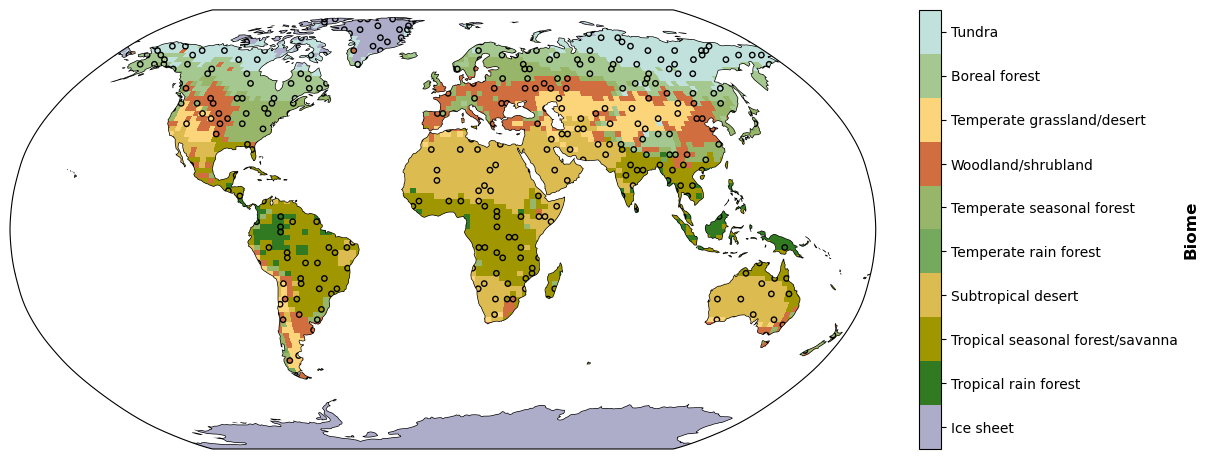

In [26]:
plotting.plot_whittaker_biomes(whit_biome.biome, sparse_lats,
                               sparse_lons, height=7, width=12)
plt.savefig(os.path.join(fig_dir, 'Figure_2.png'), bbox_inches='tight')

### How many parameters did we perturb?

In [41]:
print("We perturbed", proc.count_parameters(fates_key, exclude_pars), "FATES parameters")
print("We perturbed", proc.count_parameters(clm_key), "CLM parameters")

We perturbed 137 FATES parameters
We perturbed 204 CLM parameters


### How many parameters if we treated each PFT-parameter independently?

In [47]:
print(proc.count_if_PFT_independent(fates_key, fates['default_param'],
                                    exclude_pars=exclude_pars), "FATES parameters")
print(proc.count_if_PFT_independent(clm_key, clm_oaat['default_param'],
                                    FATES=False), "CLM parameters")

1742 FATES parameters
1374 CLM parameters


### Read in data

In [55]:
# FATES SP ensemble with FATES parameters
fates_glob, fates_mean, fates_iav = proc.get_area_means_diffs(os.path.join(hist_dir, f"{fates['name']}_area_means.nc"),
                                                  fates_param_dat, variables, fates['default'], special_vars)

fates_glob2, fates_mean2, fates_iav2 = proc.get_area_means_diffs(os.path.join(hist_dir, f"{fates['name']}_2_area_means.nc"),
                                                  fates_param_dat2, variables, fates['default'])
fates_glob3, fates_mean3, fates_iav3 = proc.get_area_means_diffs(os.path.join(hist_dir, f"{fates['name']}_3_area_means.nc"),
                                                  fates_param_dat3, variables, fates['default'])

# FATES SP ensemble with CLM parameters
fatesclm_glob, fatesclm_mean, fatesclm_iav = proc.get_area_means_diffs(os.path.join(hist_dir, f"{fates_clm['name']}_area_means.nc"),
                                       clm_param_dat, variables, fates_clm['default'])
fatesclm_glob2, fatesclm_mean2, fatesclm_iav2 = proc.get_area_means_diffs(os.path.join(hist_dir, f"{fates_clm['name']}_2_area_means.nc"),
                                       clm_param_dat, variables, fates_clm['default'])
fatesclm_glob3, fatesclm_mean3, fatesclm_iav3 = proc.get_area_means_diffs(os.path.join(hist_dir, f"{fates_clm['name']}_3_area_means.nc"),
                                       clm_param_dat, variables, fates_clm['default'])

# CLM SP ensemble with CLM parameters
clm_glob, clm_mean, clm_iav = proc.get_area_means_diffs(os.path.join(hist_dir, f"{clm_oaat['name']}_area_means.nc"),
                                       clm_param_dat, variables, clm_oaat['default'])

# combine FATES ensembles
fates_glob_combo = proc.get_combined(fates_glob, fatesclm_glob, 'fates parameters', 'clm parameters')
fates_glob_combo_mean = proc.get_combined(fates_mean, fatesclm_mean, 'fates parameters', 'clm parameters')
fates_glob_combo_iav = proc.get_combined(fates_iav, fatesclm_iav, 'fates parameters', 'clm parameters')

fates_glob_combo2 = proc.get_combined(fates_glob2, fatesclm_glob2, 'fates parameters', 'clm parameters')
fates_glob_combo_mean2 = proc.get_combined(fates_mean2, fatesclm_mean2, 'fates parameters', 'clm parameters')
fates_glob_combo_iav2 = proc.get_combined(fates_iav2, fatesclm_iav2, 'fates parameters', 'clm parameters')

fates_glob_combo3 = proc.get_combined(fates_glob3, fatesclm_glob3, 'fates parameters', 'clm parameters')
fates_glob_combo_mean3 = proc.get_combined(fates_mean3, fatesclm_mean3, 'fates parameters', 'clm parameters')
fates_glob_combo_iav3 = proc.get_combined(fates_iav3, fatesclm_iav3, 'fates parameters', 'clm parameters')

fates_default = fates_mean.isel(ensemble=0)
clm_default = clm_mean.isel(ensemble=0)

In [57]:
# get pandas data frame with global annual means
active_df = proc.get_active_ensemble_df(clm_mean, fates_glob_combo_mean)

fates_active_ens2 = fates_glob_combo_mean2.to_pandas().reset_index().drop(columns=['ensemble'])
fates_active_ens2['model'] = 'FATES'

fates_active_ens3 = fates_glob_combo_mean3.to_pandas().reset_index().drop(columns=['ensemble'])
fates_active_ens3['model'] = 'FATES'

## Find non-zero parameters

In [61]:
# find non-zero parameters for all simulations
nonzero_params = proc.get_params(fates_glob, fatesclm_glob, clm_glob)
all_params = proc.classify_params(all_params, nonzero_params)
fates_params = np.append(nonzero_params['fates'], nonzero_params['fates_clm'])

### How many active CLM parameters?

In [62]:
print("In total:", len(nonzero_params['clm']), "influenced CLM-SP")
print("In total:", len(nonzero_params['fates_clm']), "influenced CLM-FATES-SP")
print("Of these:", len(nonzero_params['common']), "influenced both")

In total: 114 influenced CLM-SP
In total: 56 influenced CLM-FATES-SP
Of these: 55 influenced both


### How many active FATES parameters?

In [63]:
fates_only_params = all_params[all_params.parameter_name.isin(nonzero_params['fates_only'])].copy()
print("In total:", len(fates_only_params), "CLM and FATES parameters influenced only FATES")
print("Of these:", len(fates_only_params[fates_only_params.model == 'FATES']), "are FATES parameters")
print("and", len(fates_only_params[fates_only_params.model == 'CLM']), "are CLM parameters")

In total: 47 CLM and FATES parameters influenced only FATES
Of these: 46 are FATES parameters
and 1 are CLM parameters


### Figure 3

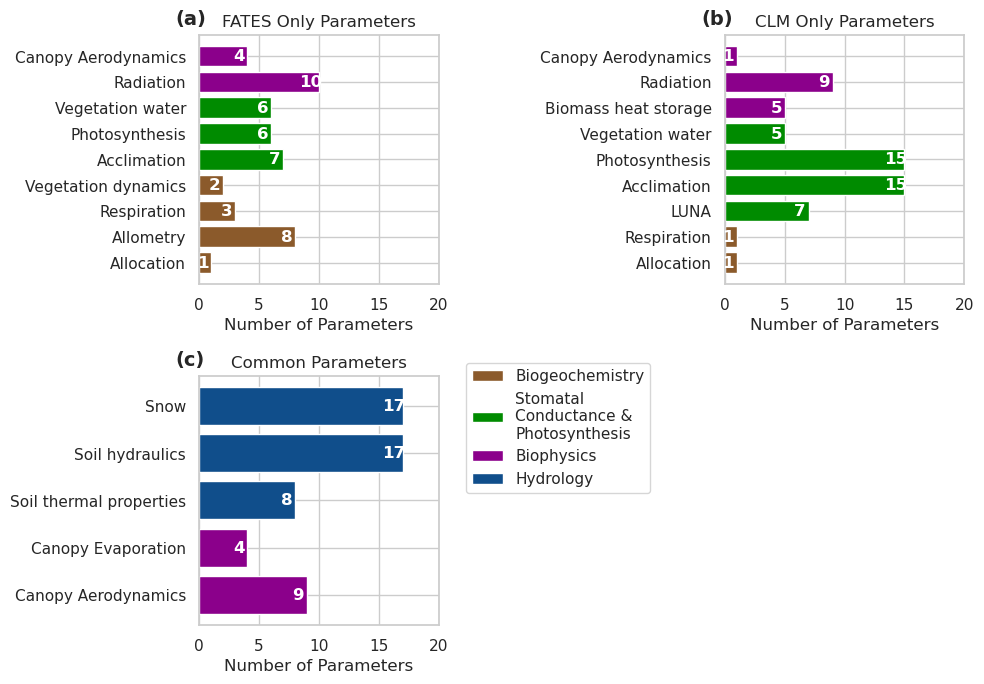

In [65]:
plotting.plot_oaat_params(all_params, nonzero_params)
plt.savefig(os.path.join(fig_dir, 'Figure_3.png'))

## Parameter Impacts

In [66]:
fates_df = active_df[active_df.model == 'FATES'].copy()
clm_df = active_df[active_df.model == 'CLM'].copy()

### How many parameters have a greater than 1% effect?

In [67]:
tol = 1.0

In [70]:
percent_params, number = proc.get_pct_diff(fates_df, 'GPP', fates_default, tol=tol)
print(f"{number} active parameters have a >{tol}% on FATES GPP ({round(percent_params, 0)}%)")

25 active parameters have a >1.0% on FATES GPP (25.0%)


In [69]:
percent_params, number = proc.get_pct_diff(clm_df, 'GPP', clm_default, tol=tol)
print(f"{number} active parameters have a >{tol}% on CLM GPP ({round(percent_params, 0)}%)")

36 active parameters have a >1.0% on CLM GPP (32.0%)


## Contribution to overall variance

In [72]:
# cumulative variance for all variables
variance_df = proc.get_all_cumulative_variance(variables,
                                               nonzero_params['clm'],
                                               clm_mean, fates_params,
                                               fates_glob_combo_mean)

### Figure 4

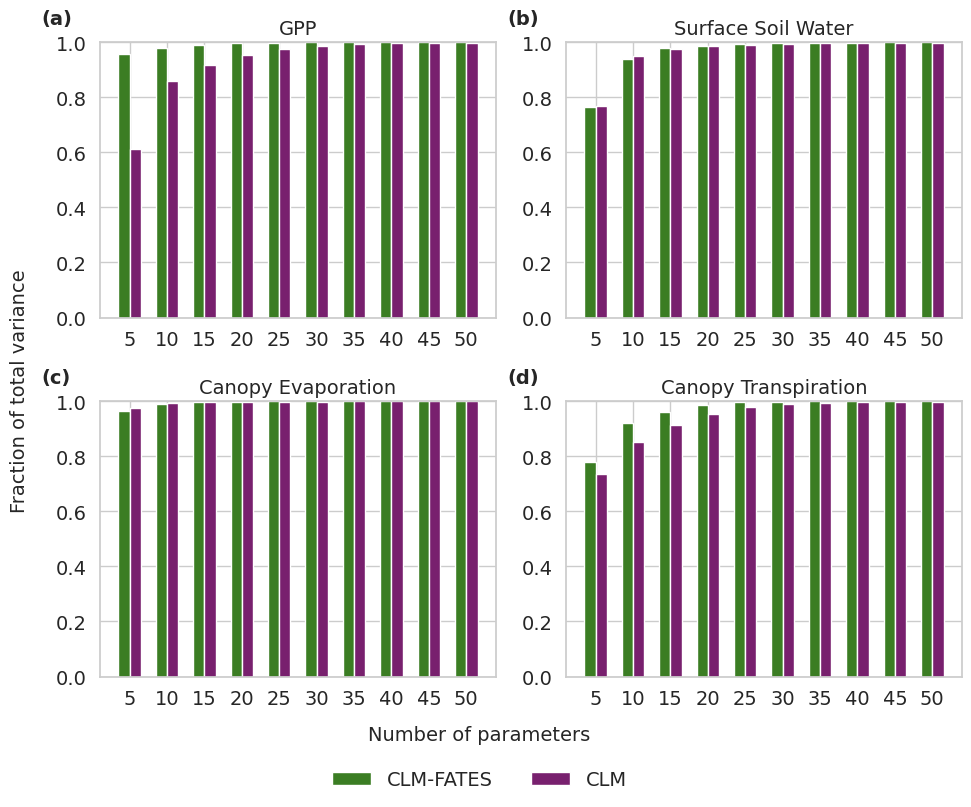

In [74]:
plotting.plot_cumulative_variance(['GPP', 'SOILWATER_10CM', 'QVEGE', 'QVEGT'], variance_df, var_dict)
plt.savefig(os.path.join(fig_dir, 'Figure_4.png'), bbox_inches='tight')

### GPP

In [77]:
# cumulative variance of GPP and number of parameters to get to 90% variance
CLMGPP_90 = proc.find_cumulative_params(nonzero_params['clm'], 'GPP', clm_mean)
FATESGPP_90 = proc.find_cumulative_params(fates_params, 'GPP', fates_glob_combo_mean)

In [78]:
print("CLM requires", len(CLMGPP_90), "parameters to achieve 90% variance in GPP")
print("FATES requires", len(FATESGPP_90), "parameters to achieve 90% variance in GPP")
print("FATES top GPP parameters:", FATESGPP_90)

CLM requires 14 parameters to achieve 90% variance in GPP
FATES requires 3 parameters to achieve 90% variance in GPP
FATES top GPP parameters: ['fates_leaf_vcmax25top' 'fates_rad_leaf_clumping_index'
 'fates_leafn_vert_scaler_coeff2']


### Soil water

In [79]:
# cumulative variance of surface soil water and number of parameters to get to 90% variance
CLMSW_90 = proc.find_cumulative_params(nonzero_params['clm'], 'SOILWATER_10CM', clm_mean)
FATESSW_90 = proc.find_cumulative_params(fates_params, 'SOILWATER_10CM', fates_glob_combo_mean)

In [80]:
print("CLM requires", len(CLMSW_90), "parameters to achieve 90% variance in soil water")
print("FATES requires", len(FATESSW_90), "parameters to achieve 90% variance in soil water")

CLM requires 9 parameters to achieve 90% variance in soil water
FATES requires 9 parameters to achieve 90% variance in soil water


### Canopy evaporation

In [81]:
# cumulative variance of surface canopy evaporation and number of parameters to get to 90% variance
CLMQVEGE_90 = proc.find_cumulative_params(nonzero_params['clm'], 'QVEGE', clm_mean)
FATESQVEGE_90 = proc.find_cumulative_params(fates_params, 'QVEGE', fates_glob_combo_mean)

In [82]:
print("CLM requires", len(CLMQVEGE_90), "parameters to achieve 90% variance in QVEGE")
print("CLM top QVEGE parameters:", CLMQVEGE_90)
print("-------")
print("FATES requires", len(FATESQVEGE_90), "parameters to achieve 90% variance in QVEGE")
print("FATES top QVEGE parameters:", FATESQVEGE_90)

CLM requires 3 parameters to achieve 90% variance in QVEGE
CLM top QVEGE parameters: ['maximum_leaf_wetted_fraction' 'liq_canopy_storage_scalar' 'dleaf']
-------
FATES requires 3 parameters to achieve 90% variance in QVEGE
FATES top QVEGE parameters: ['maximum_leaf_wetted_fraction' 'liq_canopy_storage_scalar'
 'fates_turb_leaf_diameter']


### Canopy transpiration

In [83]:
# cumulative variance of surface canopy transpiration and number of parameters to get to 90% variance
CLMQVEGT_90 = proc.find_cumulative_params(nonzero_params['clm'], 'QVEGT', clm_mean)
FATESQVEGT_90 = proc.find_cumulative_params(fates_params, 'QVEGT', fates_glob_combo_mean)

In [84]:
print("CLM requires", len(CLMQVEGT_90), "parameters to achieve 90% variance in canopy transpiration")
print("FATES requires", len(FATESQVEGT_90), "parameters to achieve 90% variance in canopy transpiration")

CLM requires 14 parameters to achieve 90% variance in canopy transpiration
FATES requires 9 parameters to achieve 90% variance in canopy transpiration


## Look at global annual ensemble ranges

### Figure 5

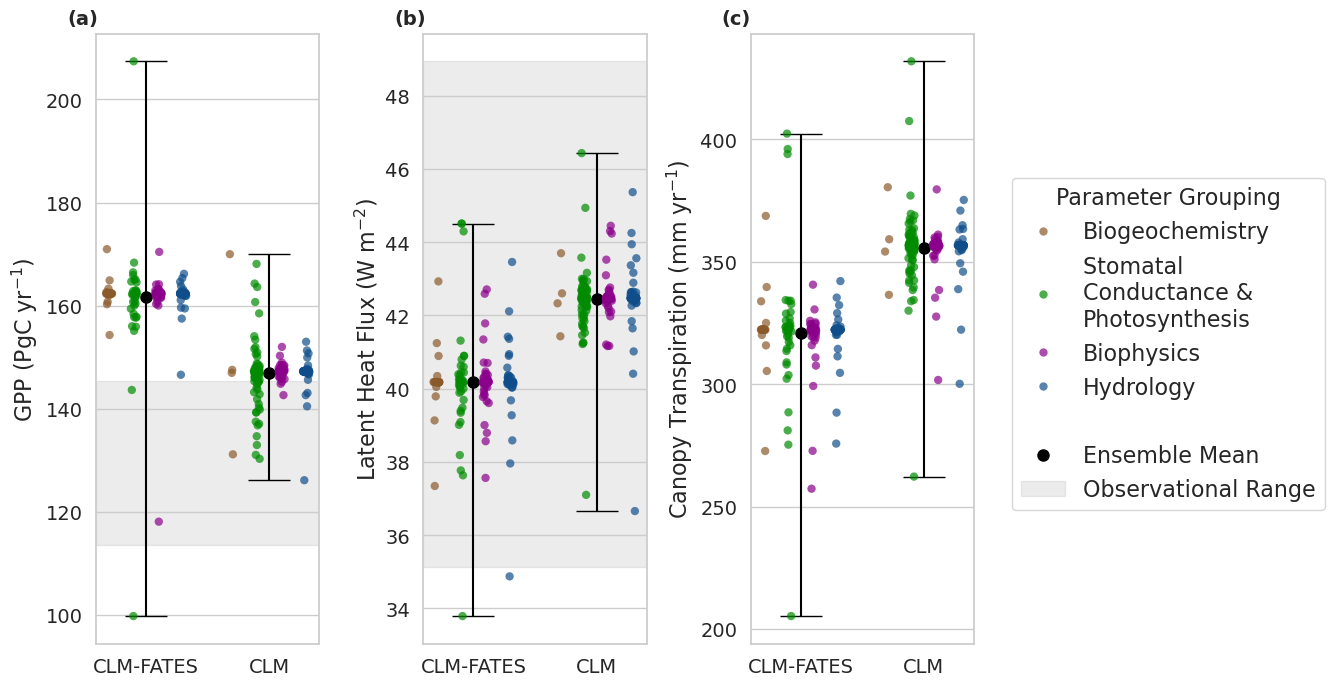

In [89]:
plotting.plot_ensemble_variance(active_df, 'CLM-FATES', 'CLM', fates_default, clm_default,
                                ['GPP', 'EFLX_LH_TOT', 'QVEGT'], var_dict,
                                obs_range=[proc.get_min_max(obs_df, 'GPP'),
                                           proc.get_min_max(obs_df, 'EFLX_LH_TOT'),
                                           None])
plt.savefig(os.path.join(fig_dir, 'Figure_5.png'), bbox_inches="tight")

### Supporting Figures S15 - S18

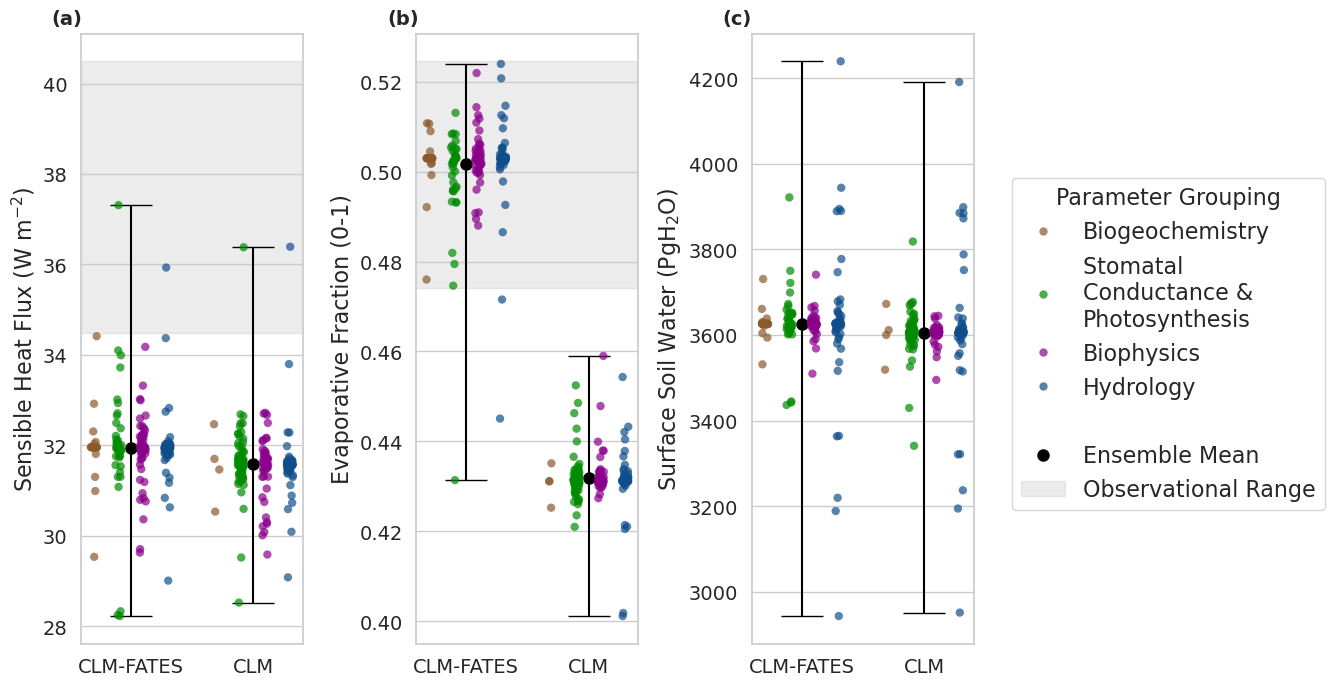

In [91]:
plotting.plot_ensemble_variance(active_df, 'CLM-FATES', 'CLM', fates_default, clm_default,
                                ['FSH', 'EF', 'SOILWATER_10CM'], var_dict,
                                obs_range=[proc.get_min_max(obs_df, 'FSH'),
                                           proc.get_min_max(obs_df, 'EF'),
                                           None])
plt.savefig(os.path.join(fig_dir, 'supplementary_figs', 'FSH_EF_SW.png'),
            bbox_inches="tight")

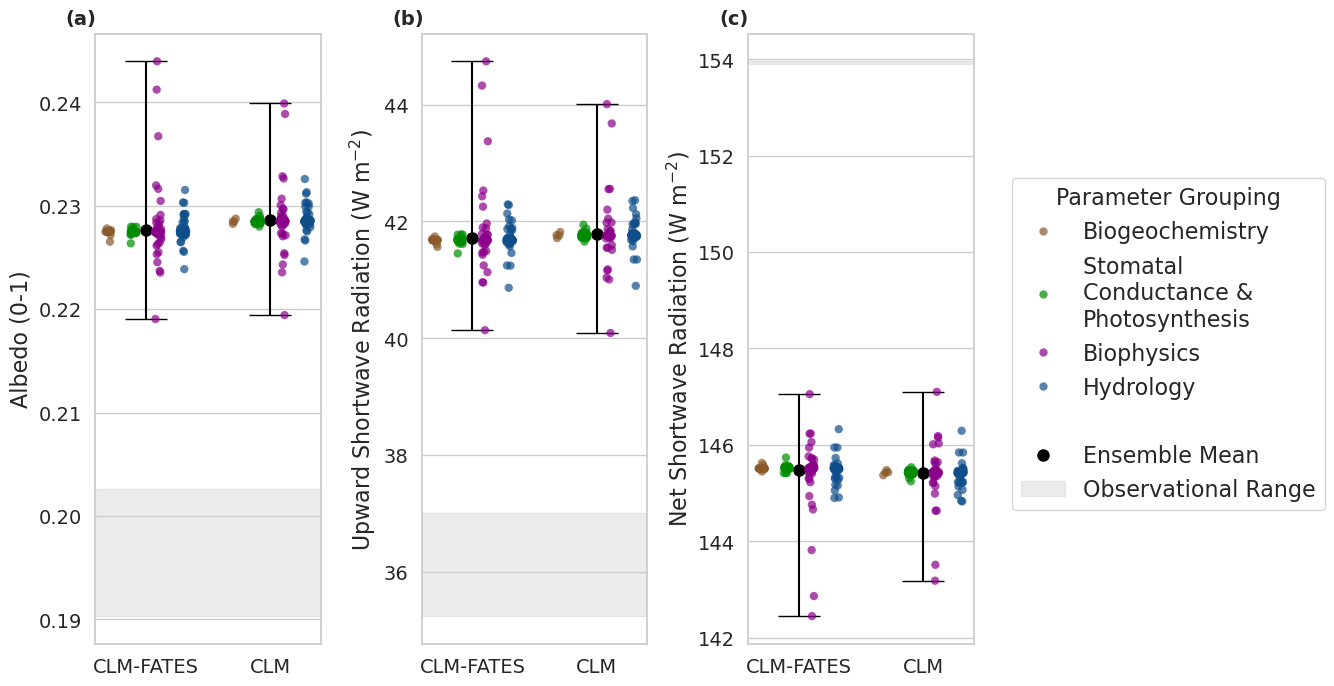

In [92]:
plotting.plot_ensemble_variance(active_df, 'CLM-FATES', 'CLM', fates_default, clm_default,
                                ['ASA', 'FSR', 'FSA'], var_dict,
                                obs_range=[proc.get_min_max(obs_df, 'ASA'),
                                           proc.get_min_max(obs_df, 'FSR'),
                                           proc.get_min_max(obs_df, 'FSA')])
plt.savefig(os.path.join(fig_dir, 'supplementary_figs', 'ASA_FSR_FSA.png'), bbox_inches="tight")

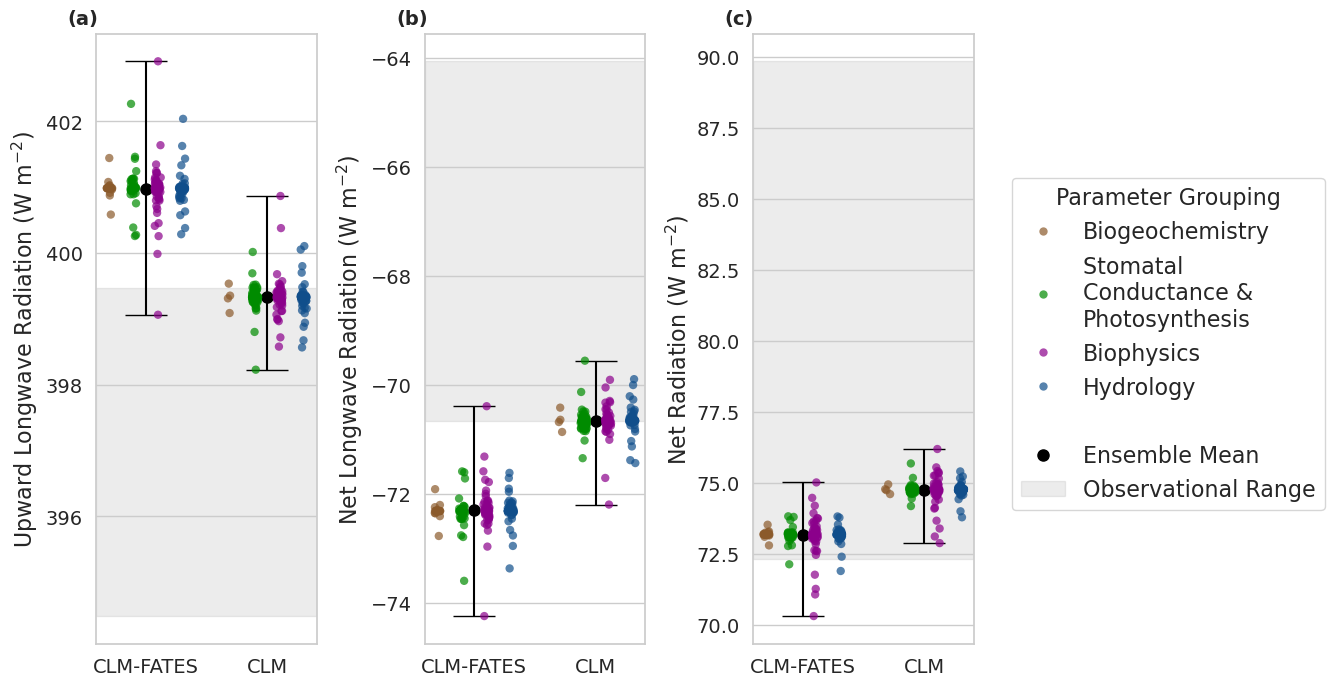

In [93]:
plotting.plot_ensemble_variance(active_df, 'CLM-FATES', 'CLM', fates_default, clm_default,
                                ['FIRE', 'RLNS', 'RN'], var_dict,
                                obs_range=[proc.get_min_max(obs_df, 'FIRE'),
                                           proc.get_min_max(obs_df, 'RLNS'),
                                           proc.get_min_max(obs_df, 'RN')])
plt.savefig(os.path.join(fig_dir, 'supplementary_figs', 'FIRE_RLNS_RN.png'), bbox_inches="tight")

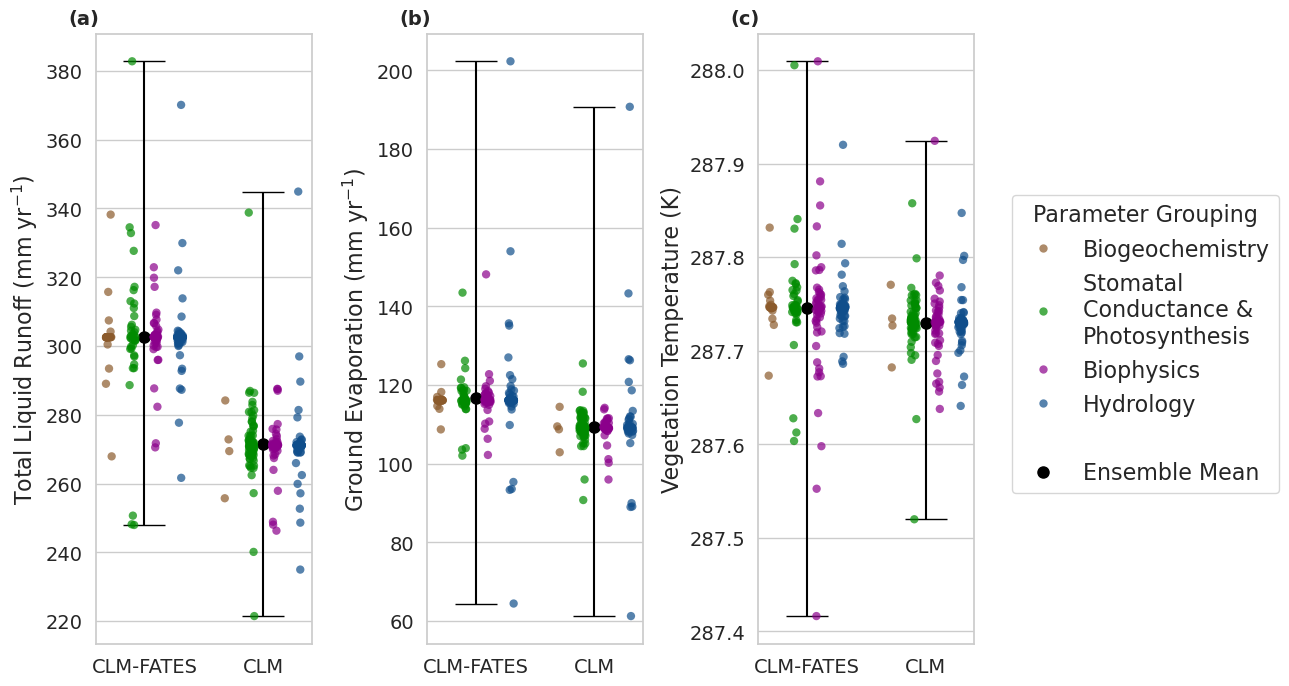

In [94]:
plotting.plot_ensemble_variance(active_df, 'CLM-FATES', 'CLM', fates_default, clm_default,
                                ['QRUNOFF', 'QSOIL', 'TV'], var_dict,
                                obs_range=None)
plt.savefig(os.path.join(fig_dir, 'supplementary_figs', 'QRUNOFF_QSOIL_TV.png'), bbox_inches="tight")

### Report some ranges

In [96]:
# calculate ranges of all variables
range_df = proc.get_both_ranges(active_df, variables)

In [97]:
proc.print_ensemble_range(range_df, 'FATES', 'GPP',
                          var_dict['GPP']['global_units'])

FATES GPP ranges from 99.81 to 207.4 PgC yr$^{-1}$
This is a range of  107.59 PgC yr$^{-1}$
And a mean of  161.74 PgC yr$^{-1}$
And a standard devaiation of  6.91 PgC yr$^{-1}$
And a variance of  47.72 PgC yr$^{-1}$
And an IQR of  0.24 PgC yr$^{-1}$


In [98]:
proc.print_ensemble_range(range_df, 'CLM', 'GPP',
                          var_dict['GPP']['global_units'])

CLM GPP ranges from 126.16 to 169.99 PgC yr$^{-1}$
This is a range of  43.83 PgC yr$^{-1}$
And a mean of  146.97 PgC yr$^{-1}$
And a standard devaiation of  4.63 PgC yr$^{-1}$
And a variance of  21.43 PgC yr$^{-1}$
And an IQR of  0.47 PgC yr$^{-1}$


In [99]:
proc.print_ensemble_range(range_df, 'FATES', 'EFLX_LH_TOT',
                          var_dict['EFLX_LH_TOT']['global_units'])

FATES EFLX_LH_TOT ranges from 33.79 to 44.51 W m$^{-2}$
This is a range of  10.72 W m$^{-2}$
And a mean of  40.17 W m$^{-2}$
And a standard devaiation of  1.09 W m$^{-2}$
And a variance of  1.18 W m$^{-2}$
And an IQR of  0.1 W m$^{-2}$


In [100]:
proc.print_ensemble_range(range_df, 'CLM', 'EFLX_LH_TOT',
                          var_dict['EFLX_LH_TOT']['global_units'])

CLM EFLX_LH_TOT ranges from 36.66 to 46.43 W m$^{-2}$
This is a range of  9.77 W m$^{-2}$
And a mean of  42.45 W m$^{-2}$
And a standard devaiation of  0.82 W m$^{-2}$
And a variance of  0.68 W m$^{-2}$
And an IQR of  0.12 W m$^{-2}$


In [101]:
proc.print_ensemble_range(range_df, 'FATES', 'QVEGT',
                          var_dict['QVEGT']['global_units'])

FATES QVEGT ranges from 205.23 to 402.38 mm yr$^{-1}$
This is a range of  197.15 mm yr$^{-1}$
And a mean of  320.96 mm yr$^{-1}$
And a standard devaiation of  17.09 mm yr$^{-1}$
And a variance of  292.19 mm yr$^{-1}$
And an IQR of  0.73 mm yr$^{-1}$


In [102]:
proc.print_ensemble_range(range_df, 'CLM', 'QVEGT',
                          var_dict['QVEGT']['global_units'])

CLM QVEGT ranges from 262.23 to 431.93 mm yr$^{-1}$
This is a range of  169.7 mm yr$^{-1}$
And a mean of  355.5 mm yr$^{-1}$
And a standard devaiation of  12.72 mm yr$^{-1}$
And a variance of  161.7 mm yr$^{-1}$
And an IQR of  1.56 mm yr$^{-1}$


## Top Parameters

In [106]:
importlib.reload(plotting)

<module 'oaat_library.plotting' from '/glade/work/afoster/oaat_fates_clm/oaat_library/plotting.py'>

In [104]:
# calculate global max - min differences
fates_meandiffs = proc.get_min_max_diff(fates_glob_combo_mean, 'FATES')
clm_meandiffs = proc.get_min_max_diff(clm_mean, 'CLM')

### Figure 6

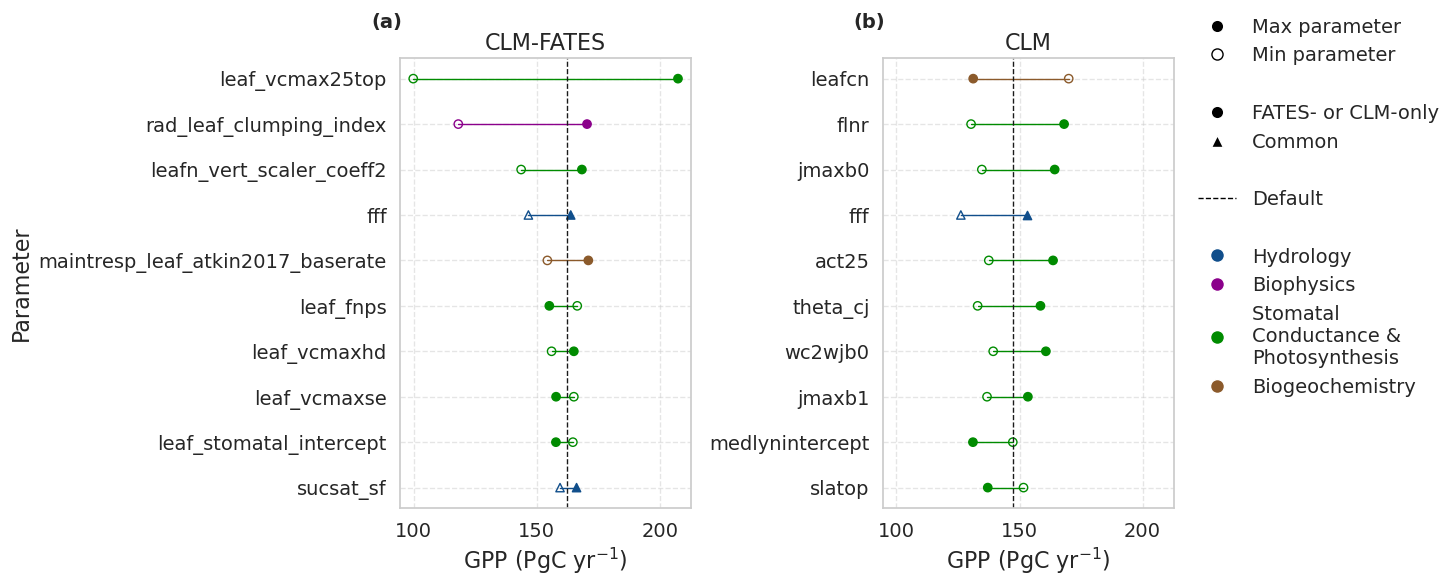

In [107]:
variable = 'GPP'
n = 10
fates_top10 = proc.get_top_n(fates_glob_combo_mean, fates_meandiffs, variable,
                             n, fates_glob_combo_mean.sel(ensemble=0))
clm_top10 = proc.get_top_n(clm_mean, clm_meandiffs, variable, n,
                           clm_mean.sel(ensemble=0))
plotting.plot_2_top_n(fates_top10, clm_top10, fates_glob_combo_mean.sel(ensemble=0),
                      clm_mean.sel(ensemble=0), all_params, variable,
                      var_dict[variable]['long_name'],
                      var_dict[variable]['global_units'])

plt.savefig(os.path.join(fig_dir, 'Figure_6.png'), bbox_inches='tight')

### Supporting Figures S19-S35

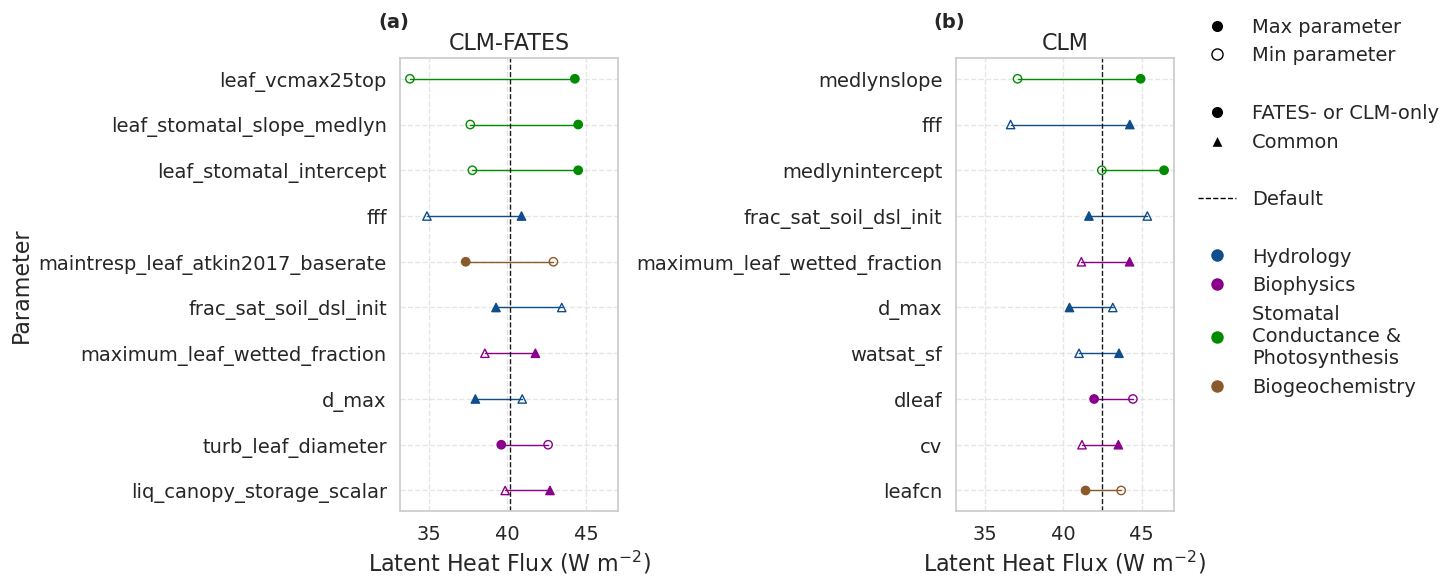

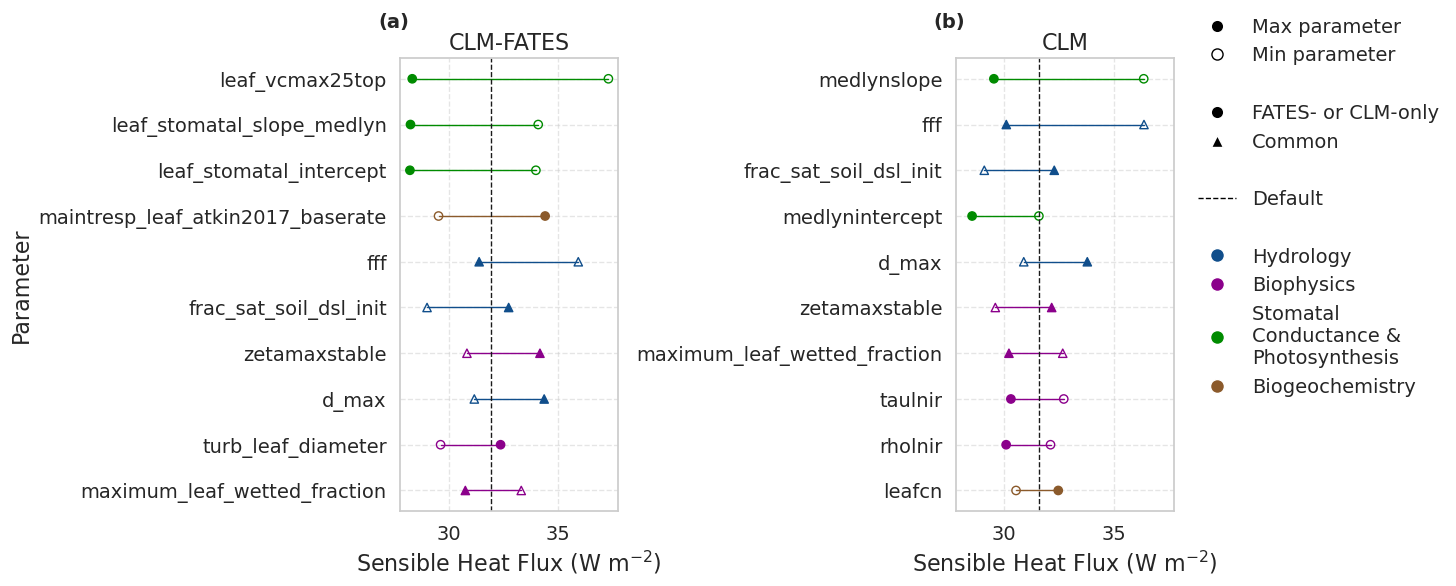

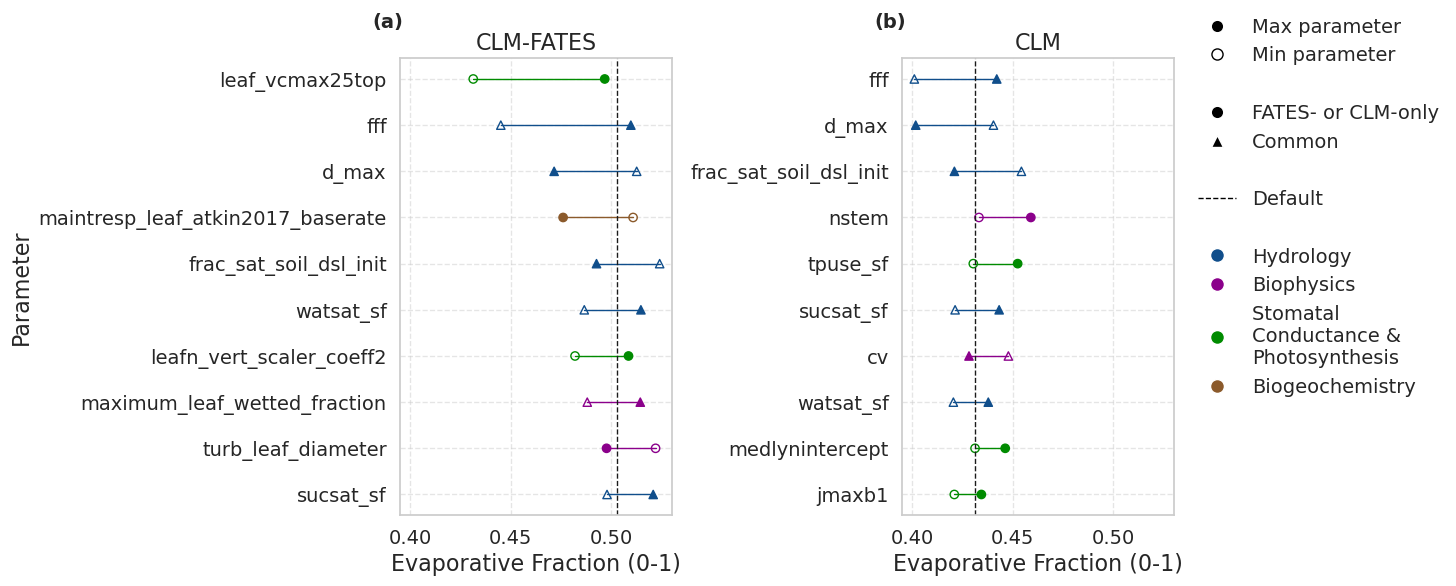

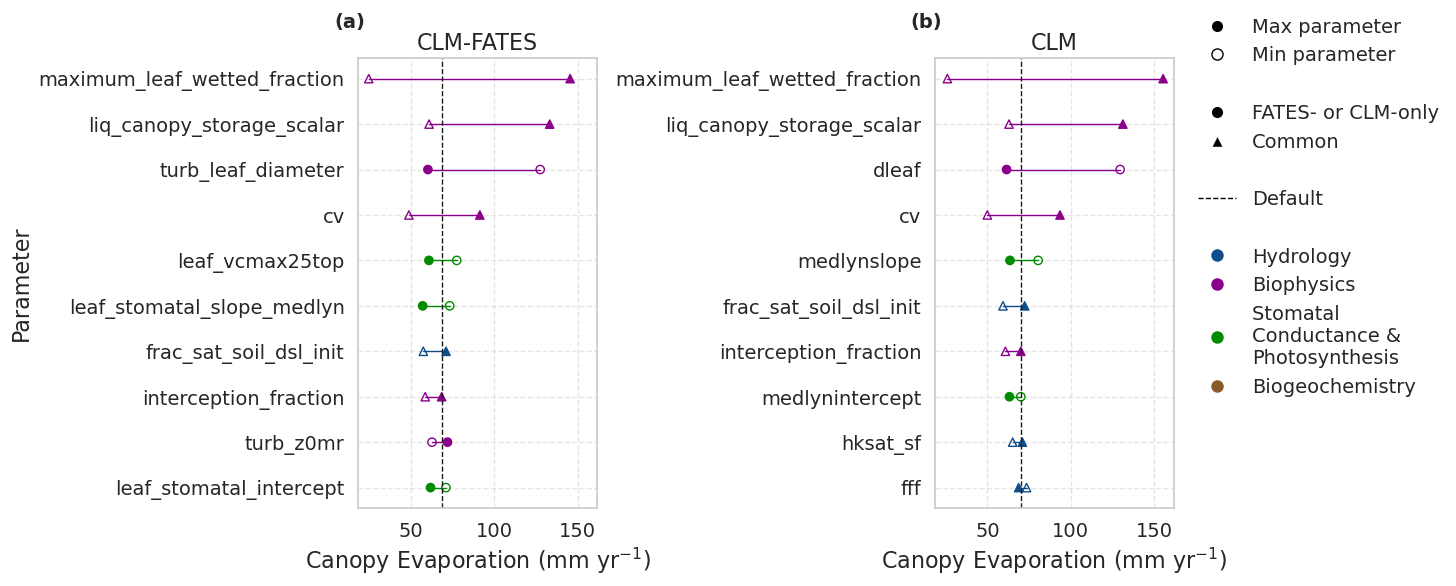

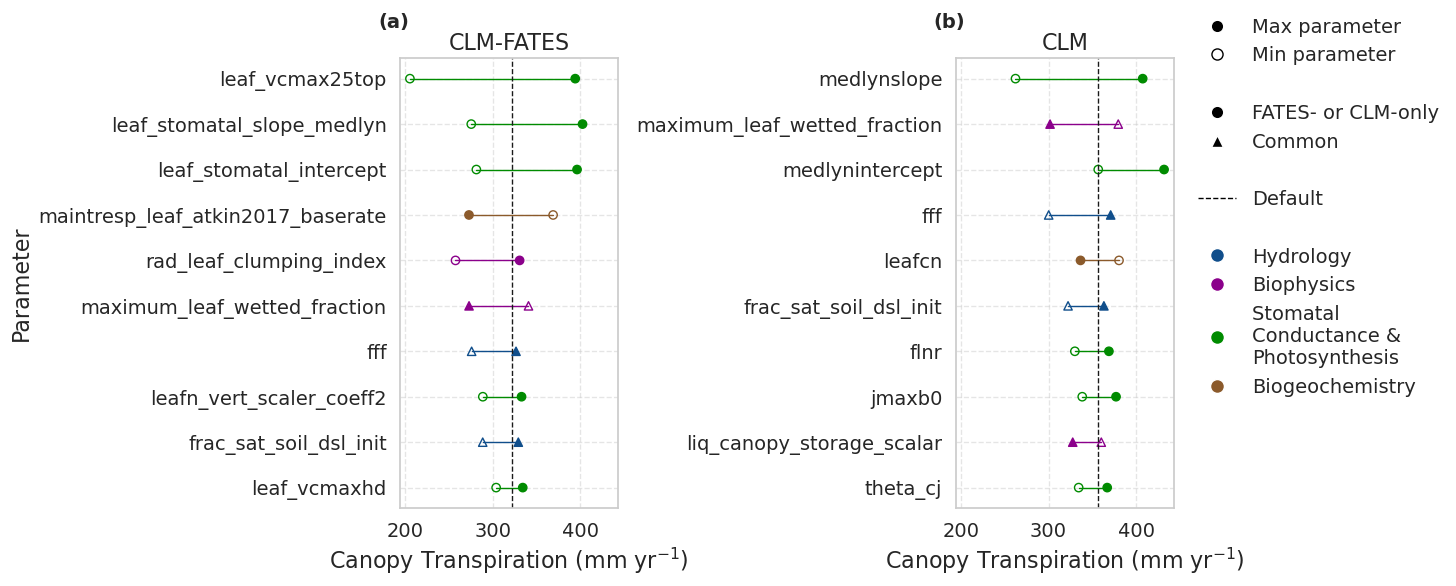

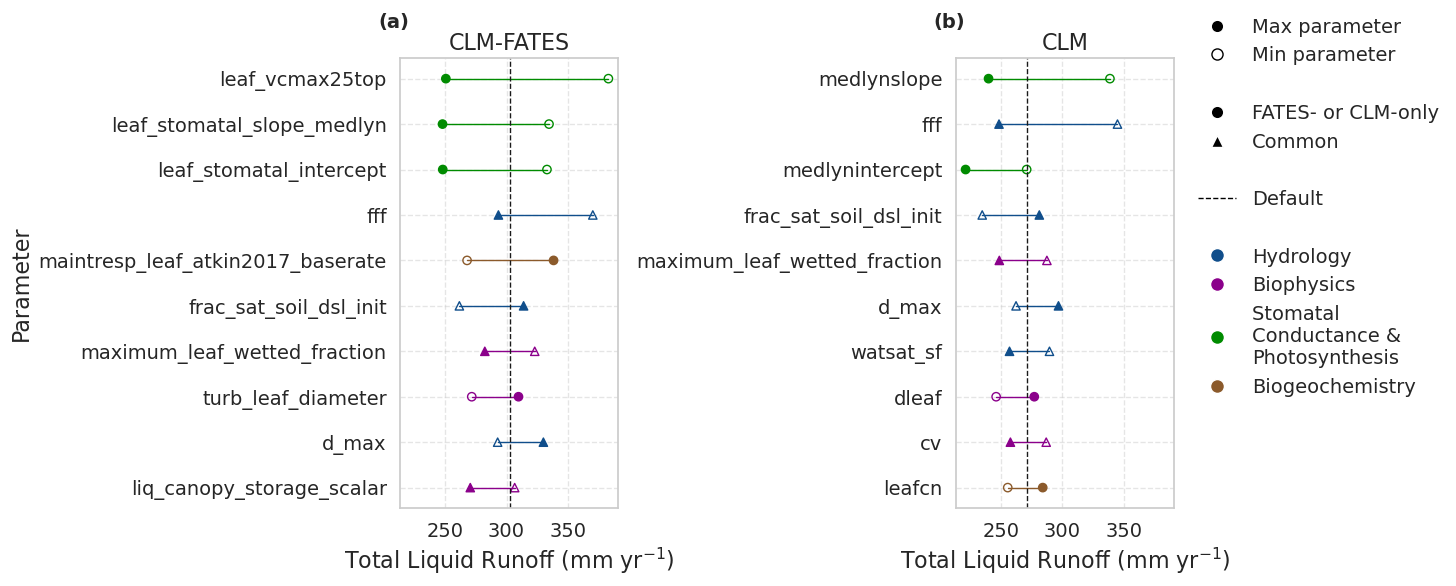

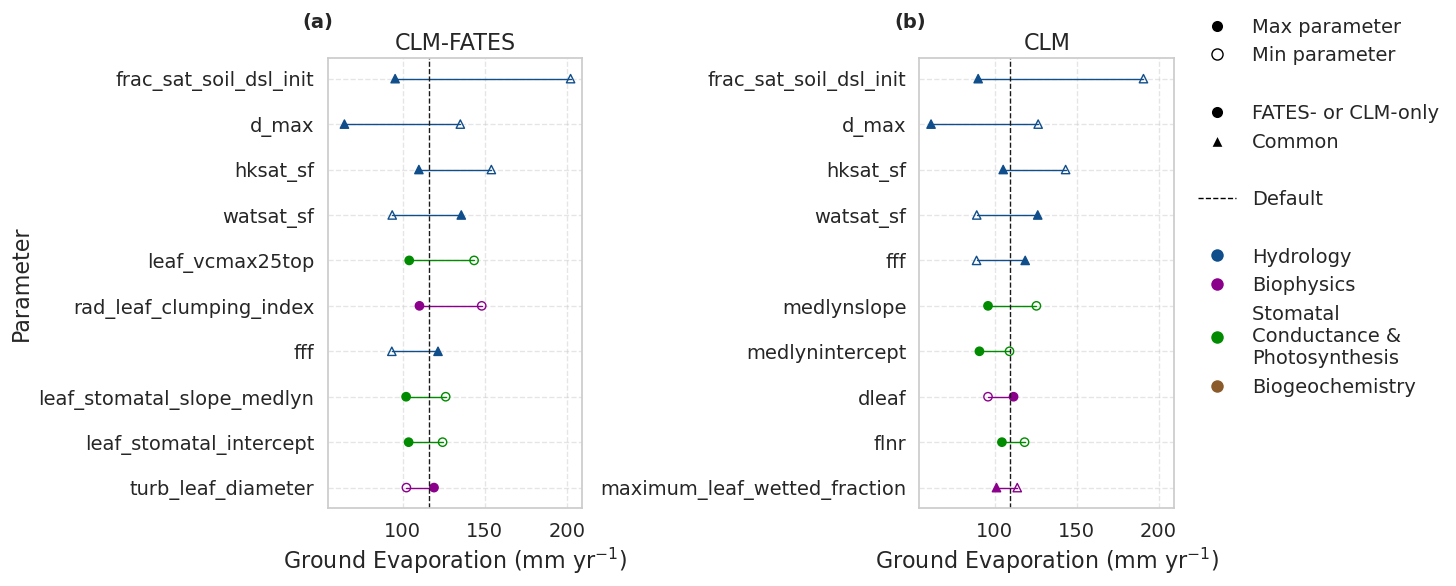

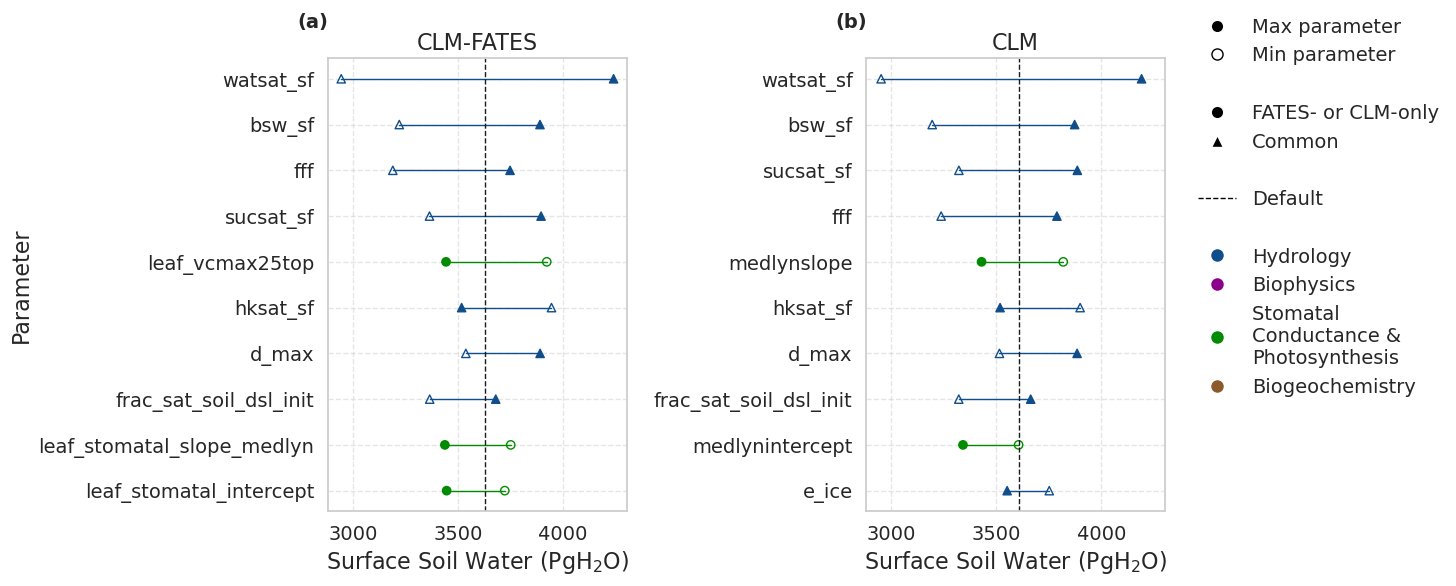

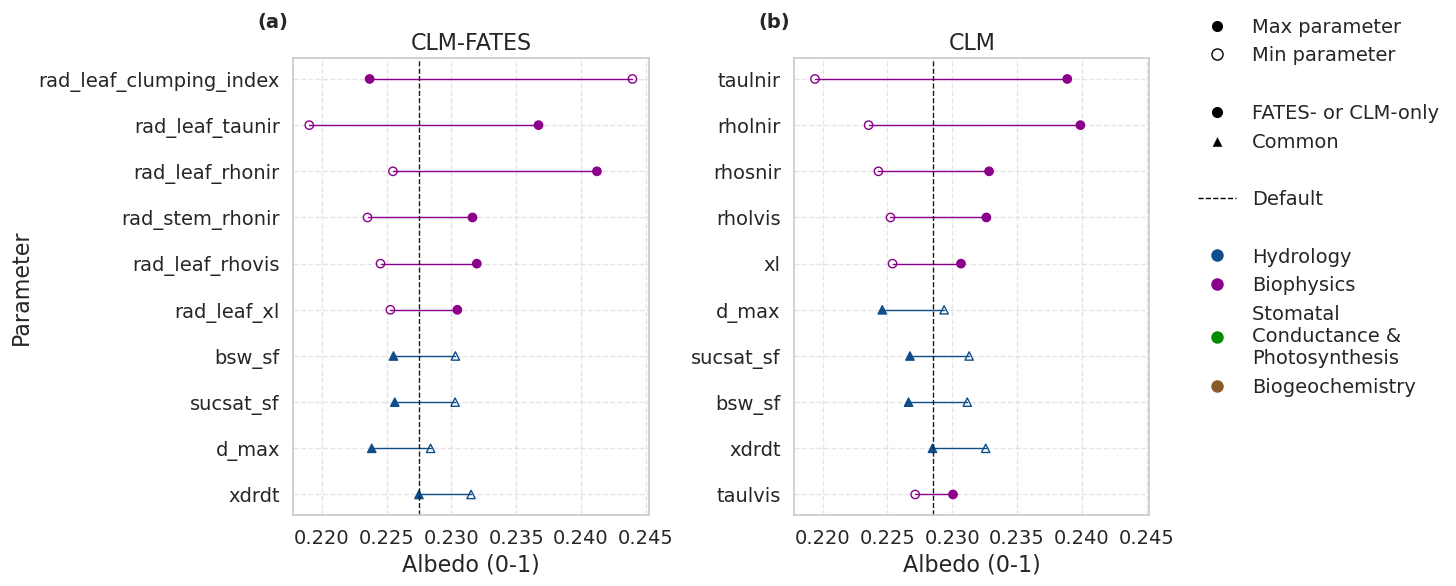

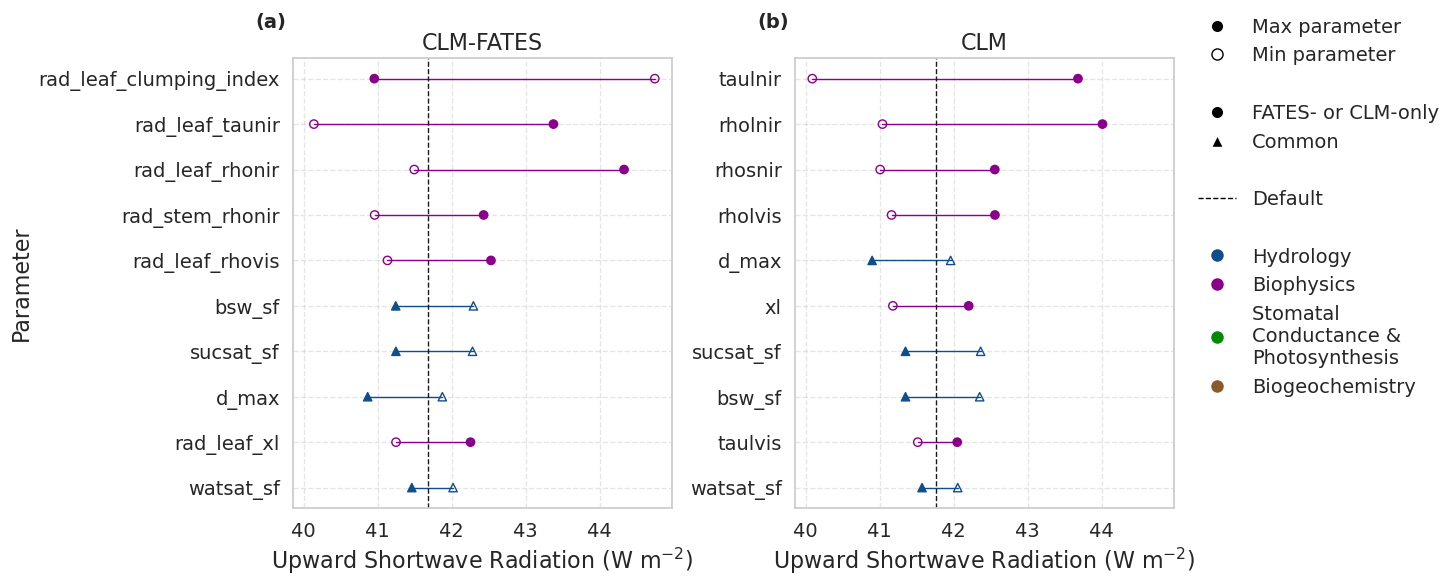

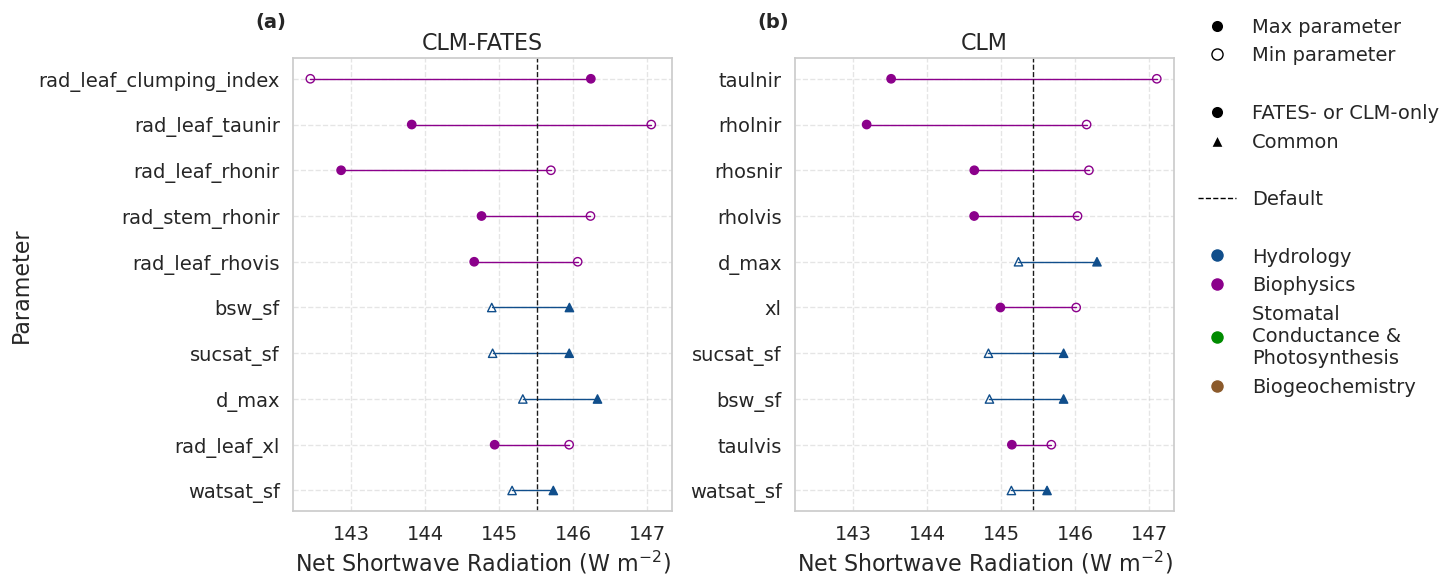

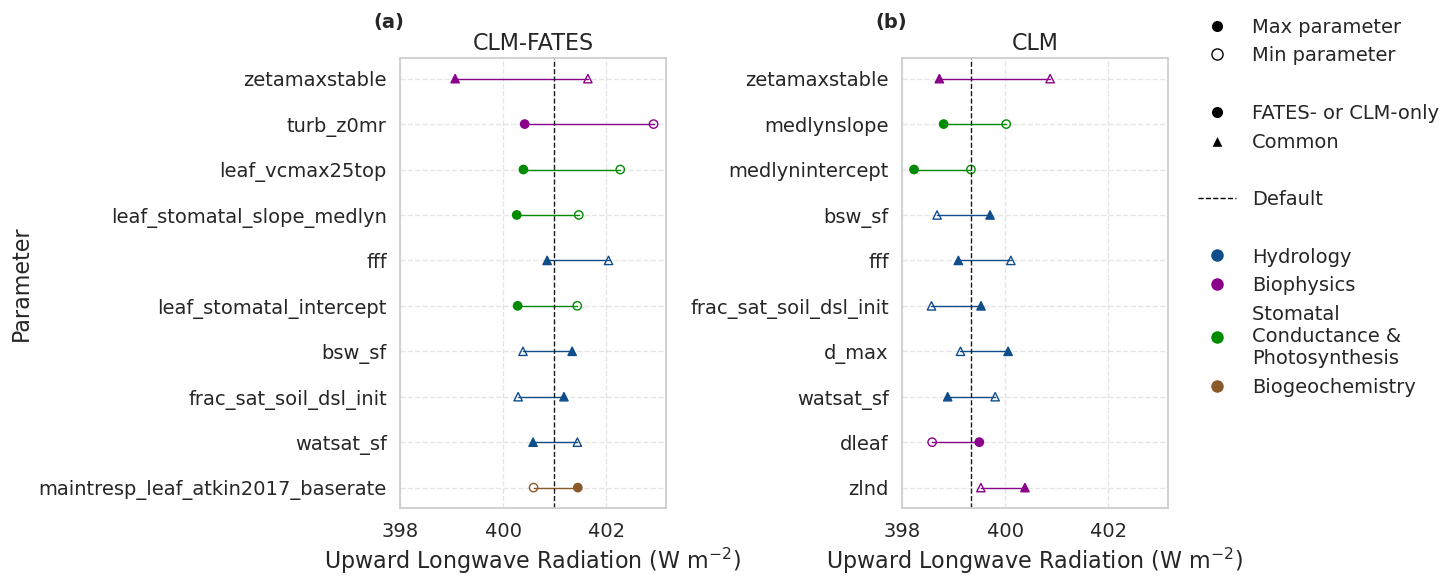

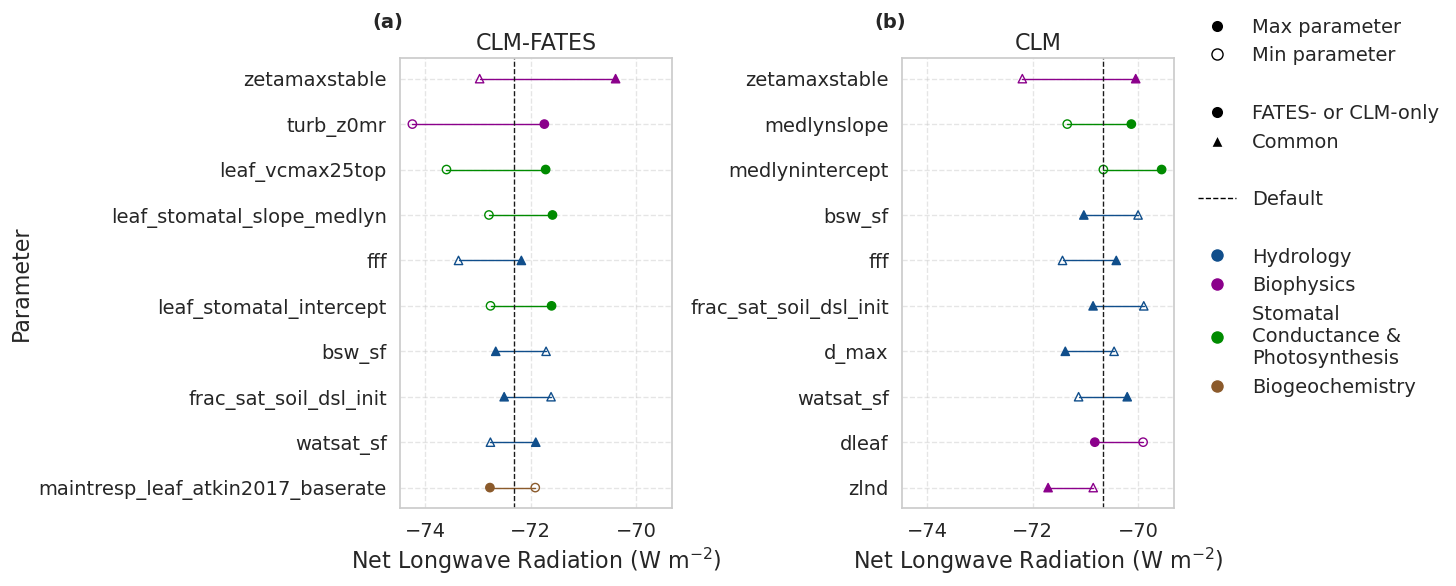

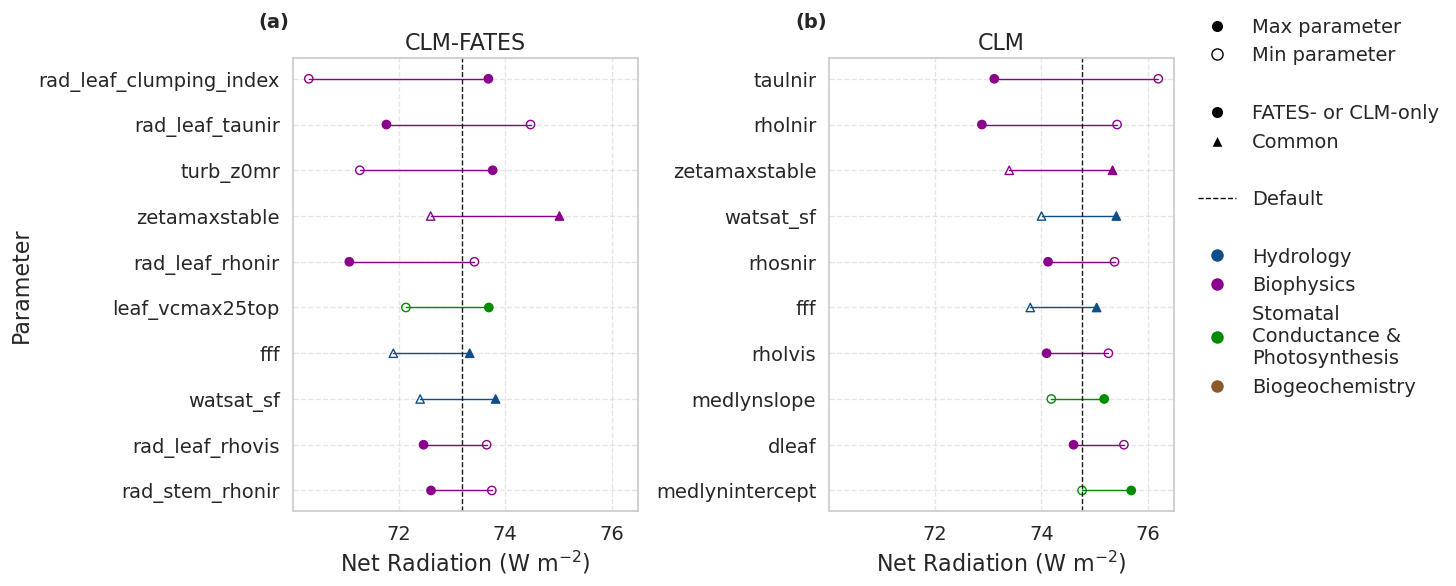

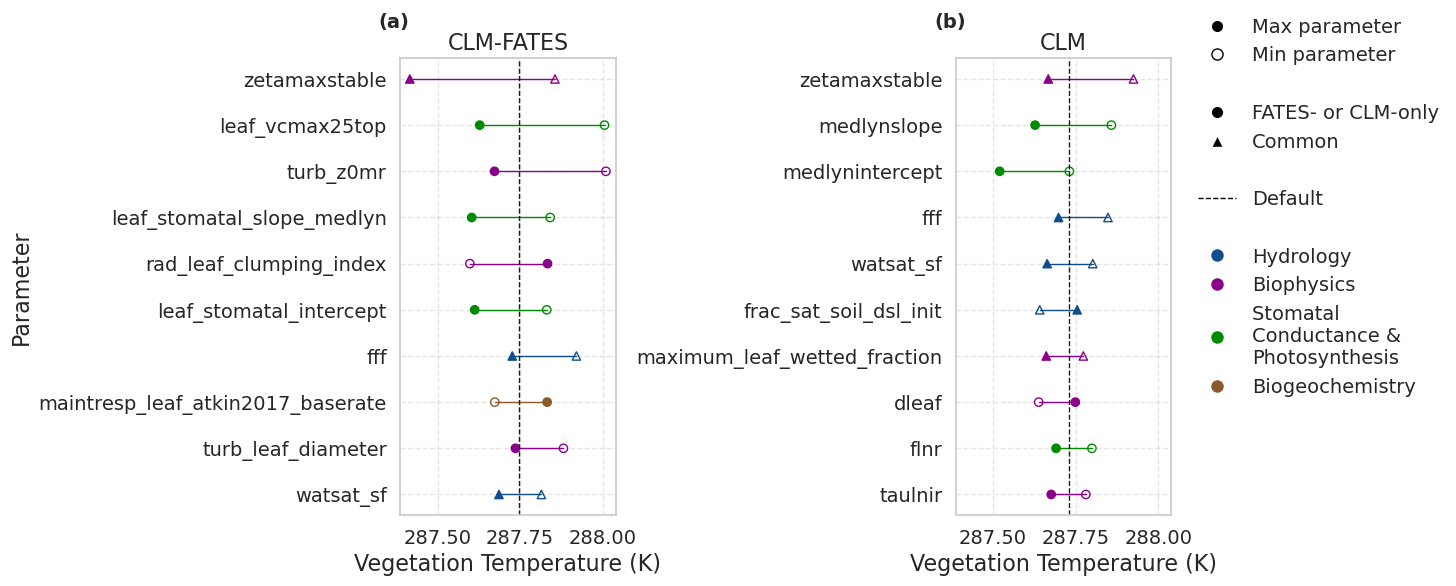

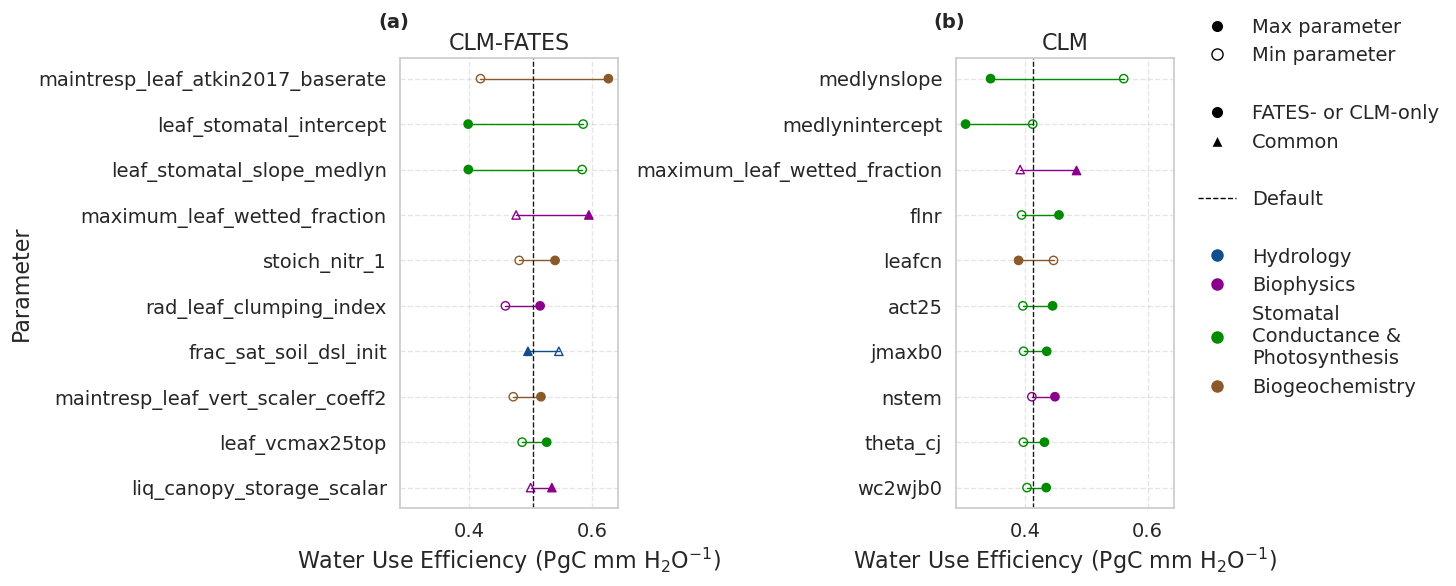

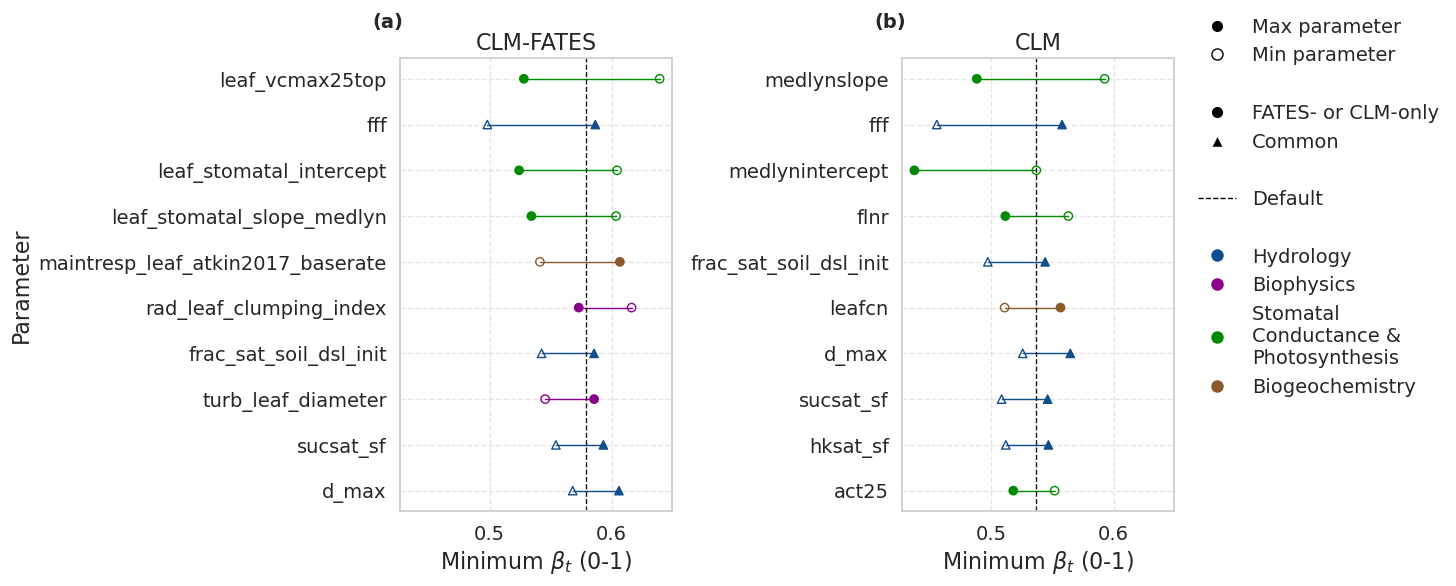

In [108]:
n = 10
for variable in variables:
    if variable != 'GPP':
        fates_top10 = proc.get_top_n(fates_glob_combo_mean, fates_meandiffs, variable,
                                 n, fates_glob_combo_mean.sel(ensemble=0))
        clm_top10 = proc.get_top_n(clm_mean, clm_meandiffs, variable, n,
                                   clm_mean.sel(ensemble=0))
        plotting.plot_2_top_n(fates_top10, clm_top10, fates_glob_combo_mean.sel(ensemble=0),
                              clm_mean.sel(ensemble=0), all_params, variable,
                              var_dict[variable]['long_name'],
                              var_dict[variable]['global_units'])
        plt.savefig(os.path.join(fig_dir, 'supplementary_figs', f'{variable}_top_10.png'),
                    bbox_inches='tight')

## Top Parameters By Biome

In [110]:
# read in biome datasets
fates_biome, fates_biome_mean, fates_biome_iav = proc.get_area_means_diffs(os.path.join(hist_dir, f"{fates['name']}_biome_area_means.nc"),
                                                                           fates_param_dat, variables, fates['default'], special_vars)
fatesclm_biome, fatesclm_biome_mean, fatesclm_biome_iav = proc.get_area_means_diffs(os.path.join(hist_dir, f"{fates_clm['name']}_biome_area_means.nc"),
                                                                                    clm_param_dat, variables, fates_clm['default'])
clm_biome, clm_biome_mean, clm_biome_iav = proc.get_area_means_diffs(os.path.join(hist_dir, f"{clm_oaat['name']}_biome_area_means.nc"),
                                       clm_param_dat, variables, clm_oaat['default'])

# combine FATES ensembles
fates_biome_combo_mean = proc.get_combined(fates_biome_mean, fatesclm_biome_mean, 'fates parameters', 'clm parameters')
fates_biome_combo_iav = proc.get_combined(fates_biome_iav, fatesclm_biome_iav, 'fates parameters', 'clm parameters')

In [111]:
# get min - max by biome
fates_biome_df = proc.get_biome_df(fates_biome_combo_mean, 'FATES')
clm_biome_df = proc.get_biome_df(clm_biome_mean, 'CLM')

In [112]:
variable = 'GPP'
fates_biome_top5 = proc.get_biome_top_n(fates_biome_combo_mean, fates_biome_df,
                                        variable, n=5)
clm_biome_top5 = proc.get_biome_top_n(clm_biome_mean, clm_biome_df,
                                      variable, n=5)

### Figure 7

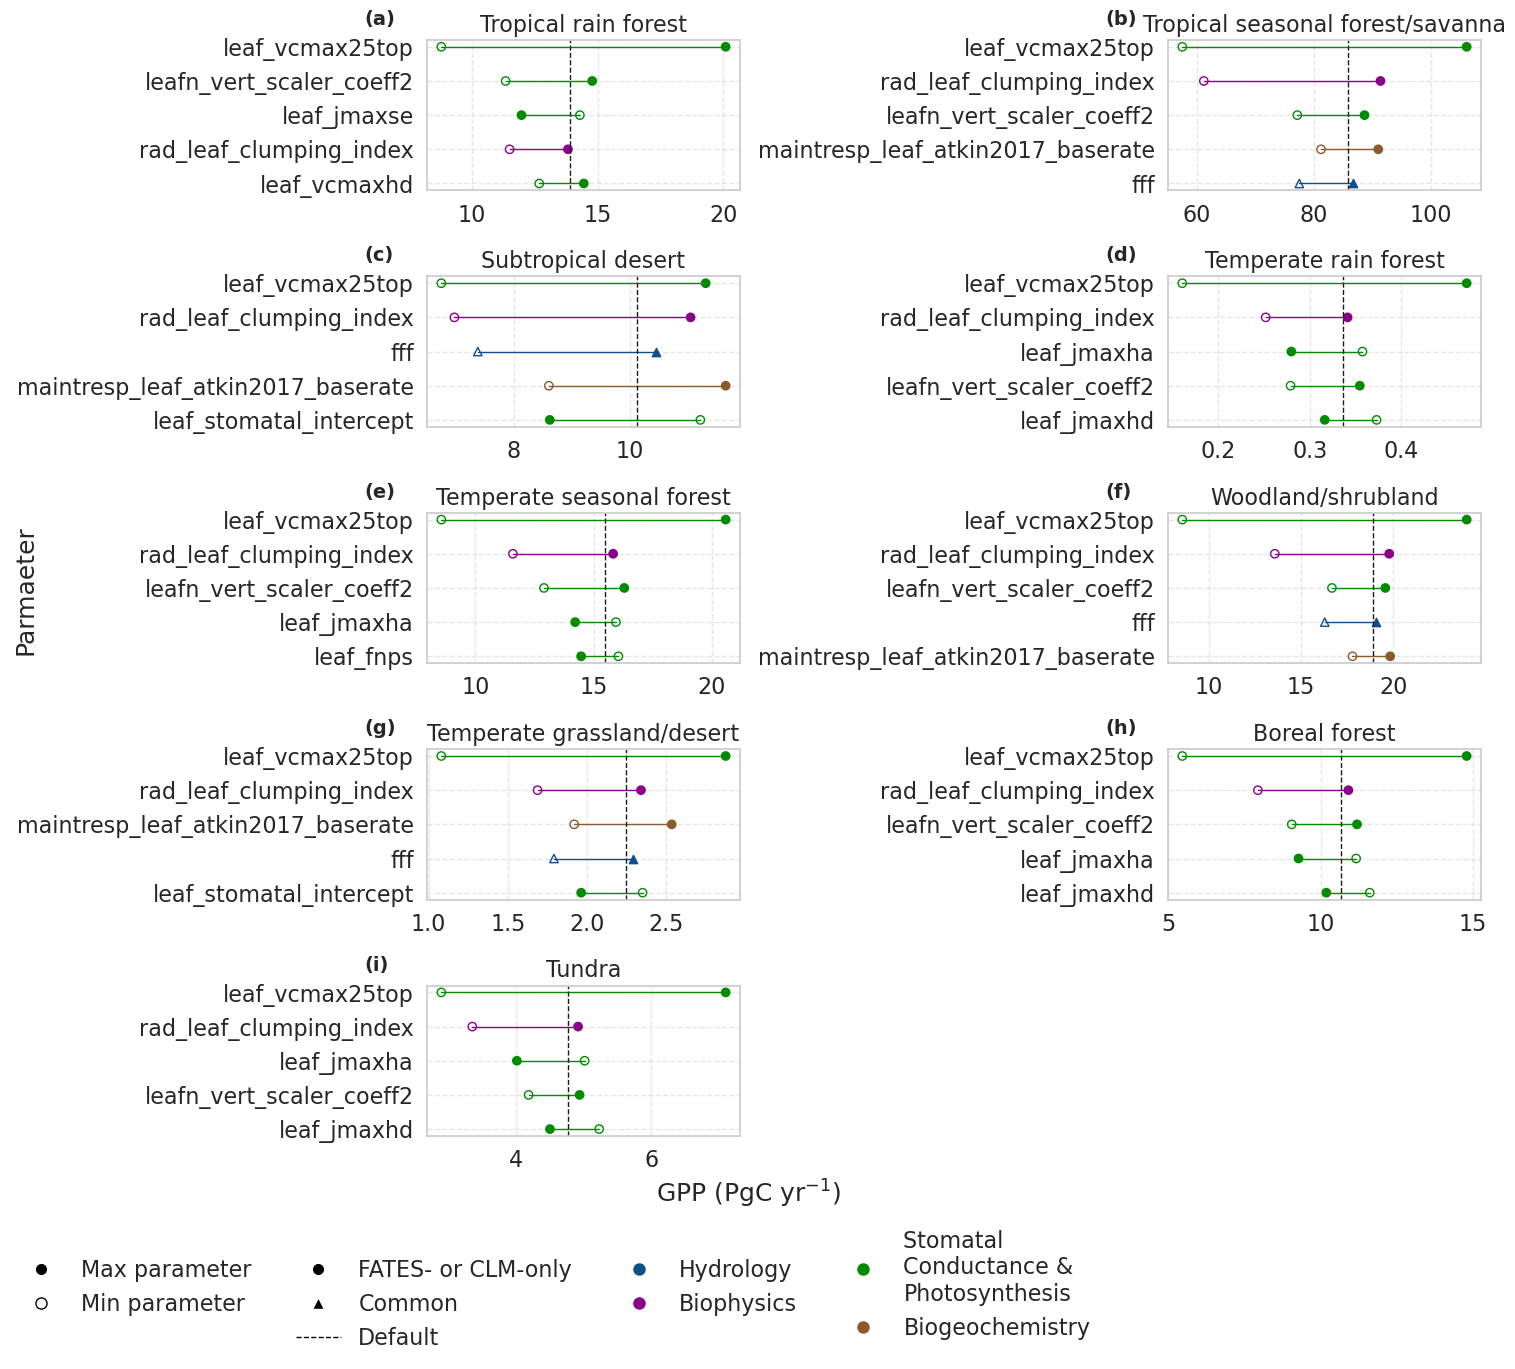

In [119]:
plotting.plot_top_n(fates_biome_top5,
                    fates_biome_combo_mean.sel(ensemble=0),
                    all_params,
                    variable, var_dict[variable]['long_name'],
                    var_dict[variable]['global_units'], by_biomes=True, width=15)
plt.savefig(os.path.join(fig_dir,  'Figure_7.png'), bbox_inches='tight')

### Figure 8

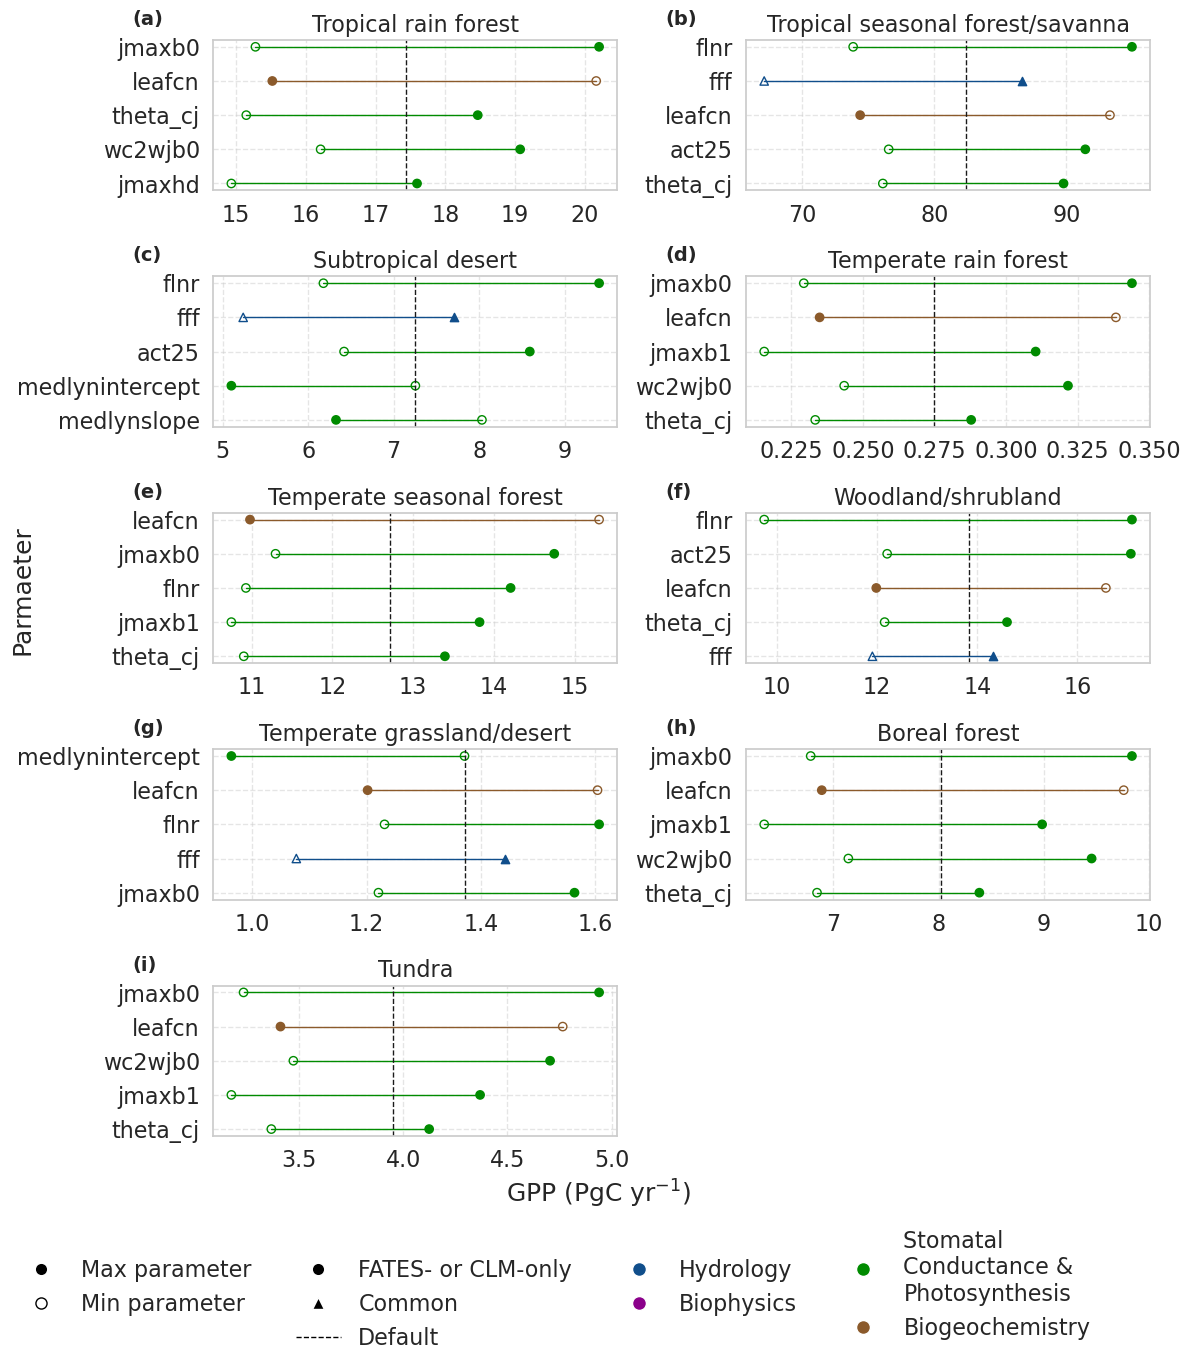

In [120]:
plotting.plot_top_n(clm_biome_top5, clm_biome_mean.sel(ensemble=0),
                    all_params,
                    variable, var_dict[variable]['long_name'],
                    var_dict[variable]['global_units'], by_biomes=True, width=12)
plt.savefig(os.path.join(fig_dir, 'Figure_8.png'), bbox_inches='tight')

## Differences between models

In [124]:
clm_reldiffs, fates_reldiffs, fatesclm_reldiffs = proc.get_all_vardiffs([v for v in variables if v != 'WUE'],
                                                                        clm_glob, fates_glob_combo, fates_glob,
                                                                        nonzero_params, 15, reldiff=True)

### Figure 9

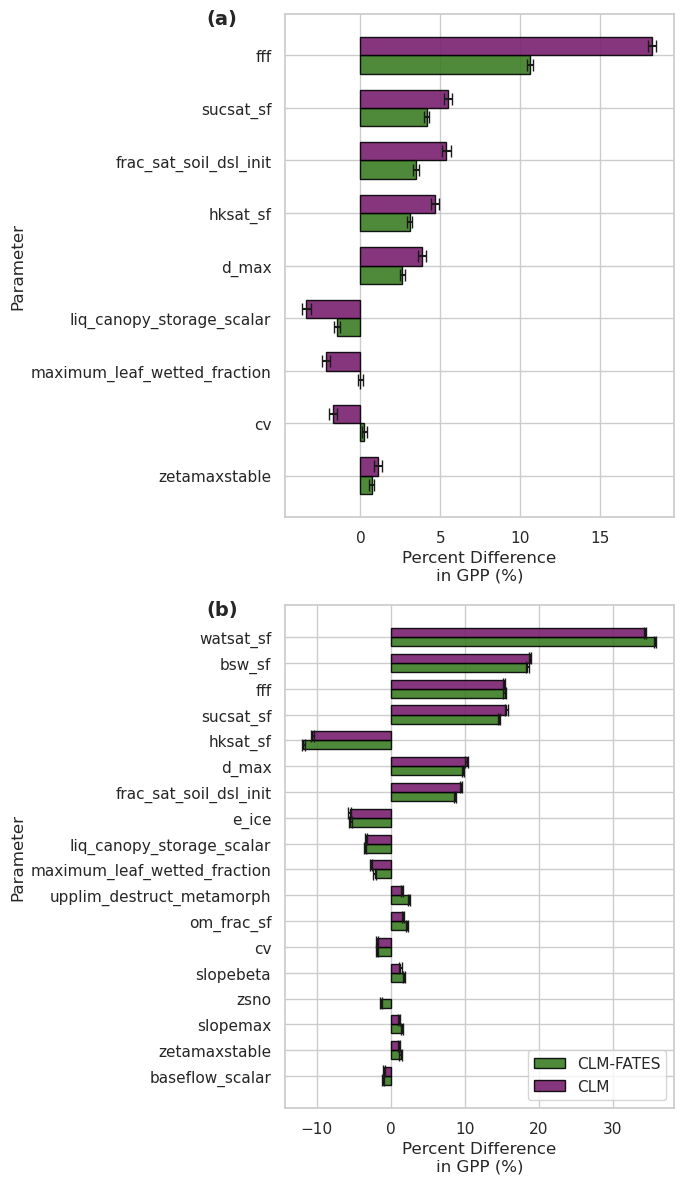

In [125]:
plotting.plot_relative_diffs(fatesclm_reldiffs, ['GPP', 'SOILWATER_10CM'], var_dict)
plt.savefig(os.path.join(fig_dir, 'Figure_9.png'), bbox_inches='tight')

### Analagous Parameters

In [126]:
param_names = {'turb_leaf_diameter': 'leaf dimension',
             'leaf_stomatal_intercept': 'stomatal intercept',
             'leaf_stomatal_slope_medlyn': 'stomatal slope',
             'leaf_slatop': 'specific leaf area'}
param_order = ['turb_leaf_diameter', 'leaf_slatop', 'leaf_stomatal_intercept',
               'leaf_stomatal_slope_medlyn']

In [131]:
clm_parameters = ['dleaf', 'slatop', 'medlynintercept', 'medlynslope']
fates_parameters = [analagous_params[param] for param in clm_parameters]
df = proc.get_compare_df(clm_reldiffs, fates_reldiffs, clm_parameters, fates_parameters)
df['variable_name'] = [var_dict[variable]['long_name'] for variable in df['variable']]
df['model_name'] = ['CLM-FATES' if model == 'FATES' else 'CLM' for model in df['model']]

### Figure 10

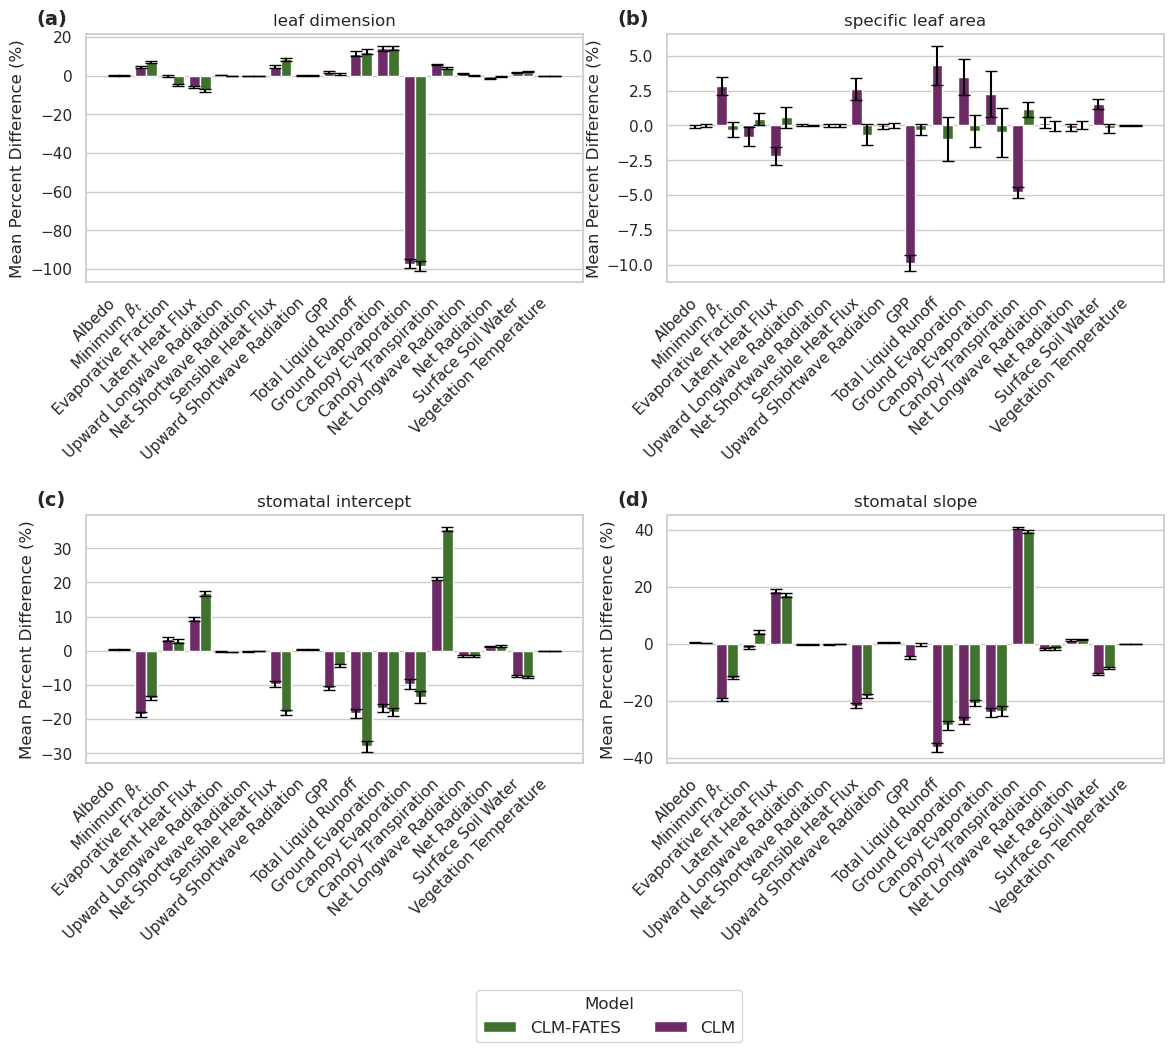

In [133]:
plotting.plot_multiple_compare_vars(df, fates_parameters, analagous_params, param_names, param_order)
plt.savefig(os.path.join(fig_dir, 'Figure_10.png'), bbox_inches='tight')

## WUE and BTRAN

### Figure 11

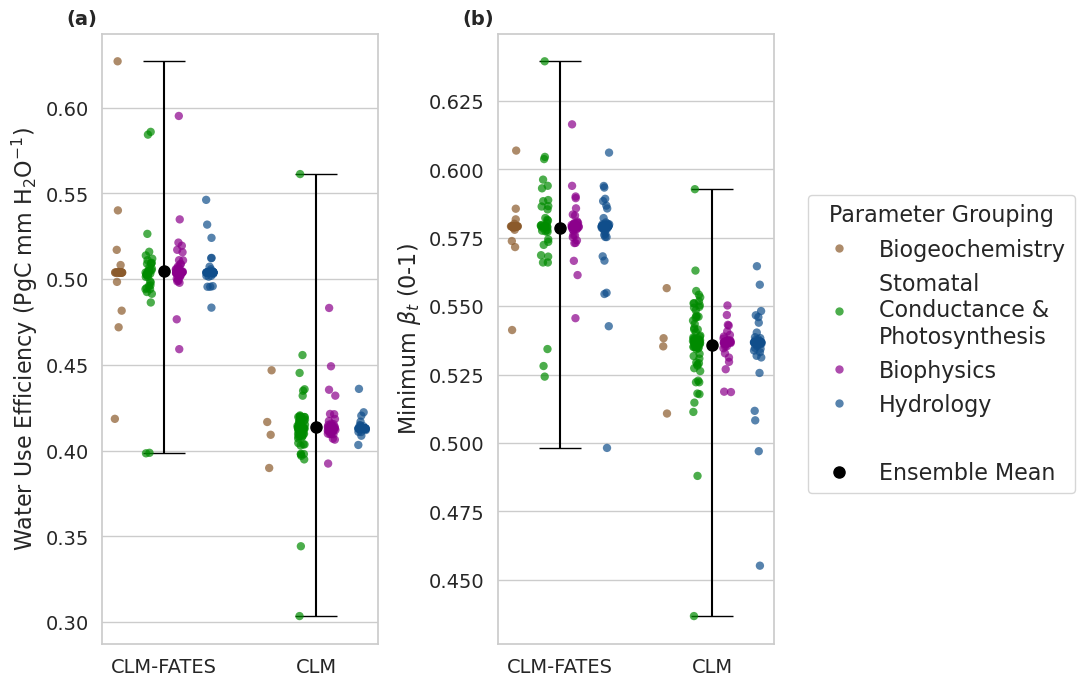

In [134]:
plotting.plot_ensemble_variance(active_df, 'CLM-FATES', 'CLM', fates_default, clm_default,
                                ['WUE', 'BTRANMN'], var_dict, width=8, height=7,
                                obs_range=None)
plt.savefig(os.path.join(fig_dir, 'Figure_11.png'), bbox_inches="tight")

In [135]:
# partition vegetation vs. non-veg parameters
active_df['model_name'] = ['CLM-FATES' if model == 'FATES' else 'CLM' for model in active_df['model']]
active_df['new_cat'] = active_df.category

active_df['category_subset'] = active_df['new_cat'].map({
    'hydrology': 'hydrology parameters',
    'vegetation': 'vegetation parameters'
}).fillna('vegetation parameters')

### Figure 12

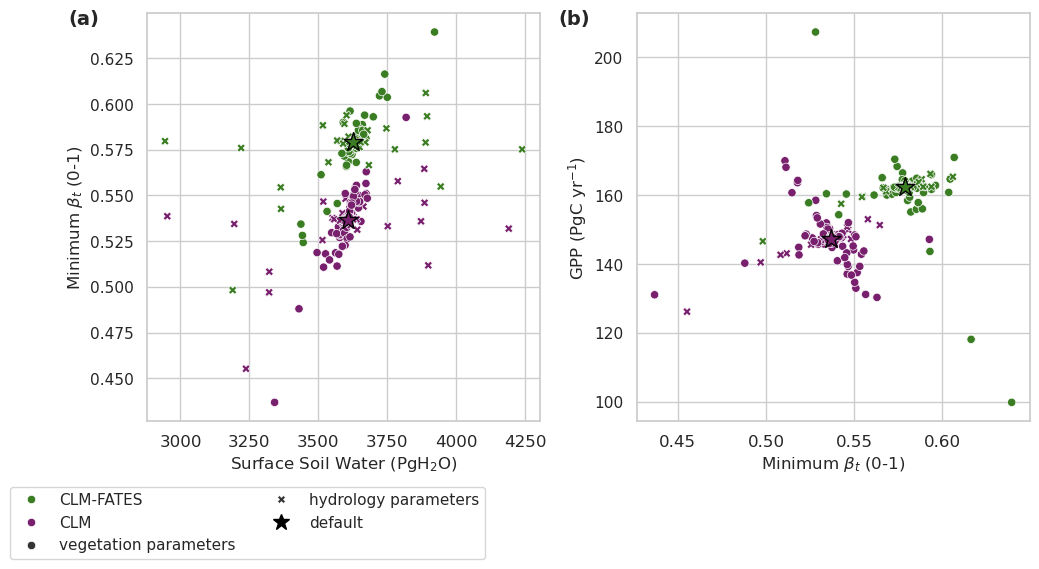

In [137]:
plotting.plot_scatter(active_df, fates_default, clm_default,
                      ['SOILWATER_10CM', 'BTRANMN', 'BTRANMN', 'GPP'],
                      var_dict)
plt.savefig(os.path.join(fig_dir, 'Figure_12.png'), bbox_inches='tight')

In [141]:
clm_slope = proc.get_slope(active_df, 'SOILWATER_10CM', 'BTRANMN',
                           'CLM', 'vegetation parameters')
fates_slope = proc.get_slope(active_df, 'SOILWATER_10CM', 'BTRANMN',
                             'CLM-FATES', 'vegetation parameters')

In [142]:
print(f"CLM has a slope of {clm_slope:.1e}")
print(f"FATES has a slope of {fates_slope:.1e}")

CLM has a slope of 3.0e-04
FATES has a slope of 2.4e-04


## Mini OAAT

### What is the default stomatal intercept for CLM and FATES?

In [143]:
# CLM
clm_oaat['default_param']['medlynintercept'].values

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100.])

In [144]:
# CLM-FATES
fates['default_param']['fates_leaf_stomatal_intercept'].values

array([10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000., 10000., 10000., 10000., 40000., 10000., 10000.])

### What is the default stomatal slope for CLM and FATES?

In [145]:
# CLM
clm_oaat['default_param']['medlynslope'].values

array([0.        , 3.096     , 3.096     , 2.3499999 , 6.63      ,
       4.11999989, 4.44999981, 4.44999981, 4.44999981, 4.69999981,
       4.69999981, 4.69999981, 2.22000003, 5.25      , 1.62      ,
       5.78999996, 5.78999996, 1.78999996, 1.78999996, 5.78999996,
       5.78999996, 5.78999996, 5.78999996, 5.78999996, 5.78999996,
       5.78999996, 5.78999996, 5.78999996, 5.78999996, 5.78999996,
       5.78999996, 5.78999996, 5.78999996, 5.78999996, 5.78999996,
       5.78999996, 5.78999996, 5.78999996, 5.78999996, 5.78999996,
       5.78999996, 5.78999996, 5.78999996, 5.78999996, 5.78999996,
       5.78999996, 5.78999996, 5.78999996, 5.78999996, 5.78999996,
       5.78999996, 5.78999996, 5.78999996, 5.78999996, 5.78999996,
       5.78999996, 5.78999996, 5.78999996, 5.78999996, 5.78999996,
       5.78999996, 5.78999996, 5.78999996, 5.78999996, 5.78999996,
       5.78999996, 5.78999996, 1.78999996, 1.78999996, 5.78999996,
       5.78999996, 1.78999996, 1.78999996, 1.78999996, 1.78999

In [146]:
# FATES
fates['default_param']['fates_leaf_stomatal_slope_medlyn'].values

array([4.1, 2.3, 2.3, 4.1, 4.4, 4.4, 4.7, 4.7, 4.7, 4.7, 4.7, 2.2, 5.3,
       1.6, 5.3, 5.3])

## Mini OAAT

In [147]:
fates_meandiffs2 = proc.get_min_max_diff(fates_glob_combo_mean2, 'FATES')
fates_meandiffs3 = proc.get_min_max_diff(fates_glob_combo_mean3, 'FATES')

fates_meandiffs2 = fates_meandiffs2[fates_meandiffs2.parameter.isin(['fates_leaf_vcmax25top', 'fates_leaf_stomatal_slope_medlyn',
                                                'fates_leaf_stomatal_intercept', 'fff'])]
fates_meandiffs3 = fates_meandiffs3[fates_meandiffs3.parameter.isin(['fates_leaf_vcmax25top', 'fates_leaf_stomatal_slope_medlyn',
                                                'fates_leaf_stomatal_intercept', 'fff'])]
fates_meandiffs_sub = fates_meandiffs[fates_meandiffs.parameter.isin(['fates_leaf_vcmax25top', 'fates_leaf_stomatal_slope_medlyn',
                                                'fates_leaf_stomatal_intercept', 'fff'])]
clm_meandiffs_sub = clm_meandiffs[clm_meandiffs.parameter.isin(['medlynslope', 'medlynintercept', 'fff'])]

### Figure 13

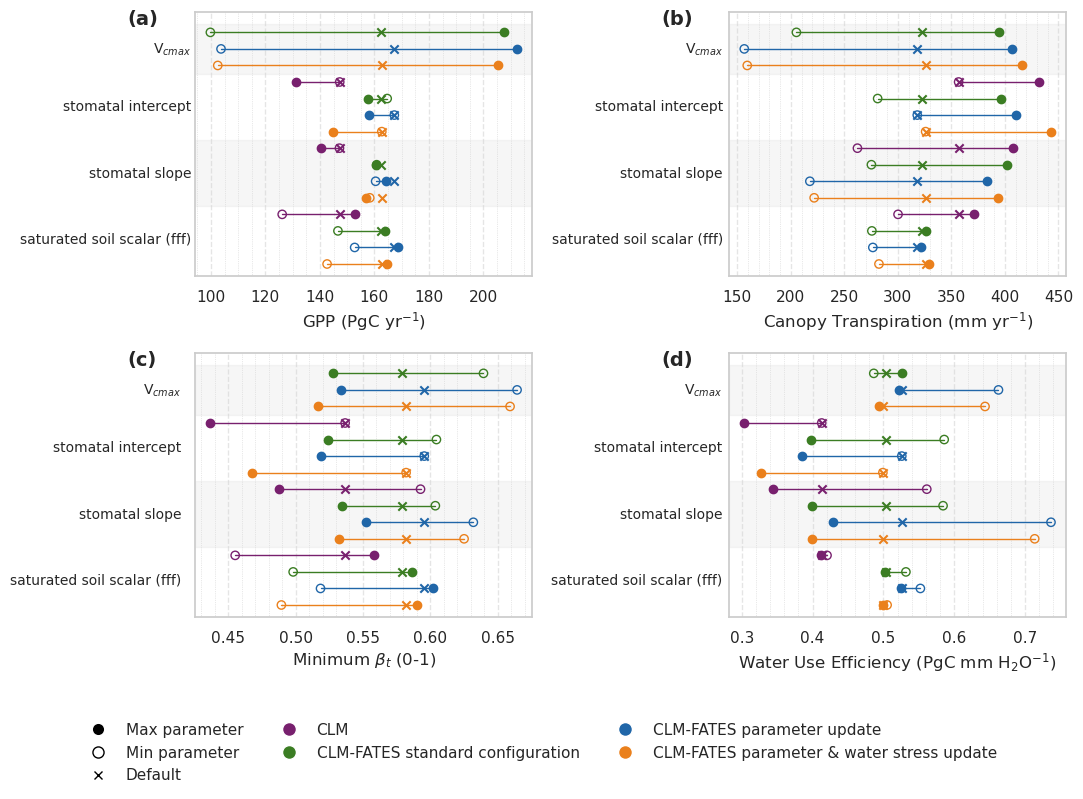

In [153]:
vars_to_plot = ['GPP', 'QVEGT', 'BTRANMN', 'WUE']
long_names = [var_dict[variable]['long_name'] for variable in vars_to_plot]
units = [var_dict[variable]['global_units'] for variable in vars_to_plot]
all_tops = []
for variable in vars_to_plot:
    all_tops.append(proc.create_combined_mini_oaat_data(variable, fates_glob_combo_mean2, fates_meandiffs2,
                                  fates_glob_combo_mean3, fates_meandiffs3, fates_glob_combo_mean,
                                  fates_meandiffs_sub, clm_mean, clm_meandiffs_sub, analagous_params))
mvs = [7.0, 20.0, 0.04, 0.14]

plotting.plot_all_mini_oaats(all_tops, long_names, units, mvs, default_line=False)
plt.savefig(os.path.join(fig_dir, 'Figure_13.png'), bbox_inches='tight')

### Maps

In [155]:
# read in global datasets
fates_maps = xr.open_dataset(os.path.join(hist_dir, f"{fates['name']}_annual_maps.nc"))
fates_maps_ens = fates_maps.where(fates_maps.ensemble > fates['default'], drop=True)
fates_maps_ens = xr.merge([fates_maps_ens, fates_param_dat], join='outer')

fates_maps2 = xr.open_dataset(os.path.join(hist_dir, f"{fates['name']}_2_annual_maps.nc"))
fates_maps_ens2 = fates_maps2.where(fates_maps2.ensemble > fates['default'], drop=True)
fates_maps_ens2 = xr.merge([fates_maps_ens2, fates_param_dat2], join='outer')

fates_maps3 = xr.open_dataset(os.path.join(hist_dir, f"{fates['name']}_3_annual_maps.nc"))
fates_maps_ens3 = fates_maps3.where(fates_maps3.ensemble > fates['default'], drop=True)
fates_maps_ens3 = xr.merge([fates_maps_ens3, fates_param_dat3], join='outer')

fates_clm_maps = xr.open_dataset(os.path.join(hist_dir, f"{fates_clm['name']}_annual_maps.nc"))
fates_clm_maps_ens = fates_clm_maps.where(fates_clm_maps.ensemble > fates_clm['default'], drop=True)
fates_clm_maps_ens = xr.merge([fates_clm_maps_ens, clm_param_dat], join='outer')

clm_maps = xr.open_dataset(os.path.join(hist_dir, f"{clm_oaat['name']}_annual_maps.nc"))
clm_maps_ens = clm_maps.where(clm_maps.ensemble > clm_oaat['default'], drop=True)
clm_maps_ens = xr.merge([clm_maps_ens, clm_param_dat], join='outer')

In [156]:
# get default ensemble and calculate WUE
fates_ens_default = fates_maps.sel(ensemble=0)
fates_ens_default2 = fates_maps2.sel(ensemble=0)
fates_ens_default3 = fates_maps3.sel(ensemble=0)

fates_ens_default['WUE'] = fates_ens_default['GPP']*1000/(fates_ens_default['QVEGT'].where(fates_ens_default.QVEGT > 0.0))
fates_ens_default2['WUE'] = fates_ens_default2['GPP']*1000/(fates_ens_default2['QVEGT'].where(fates_ens_default2.QVEGT > 0.0))
fates_ens_default3['WUE'] = fates_ens_default3['GPP']*1000/(fates_ens_default3['QVEGT'].where(fates_ens_default3.QVEGT > 0.0))

### Figures S36 & S37

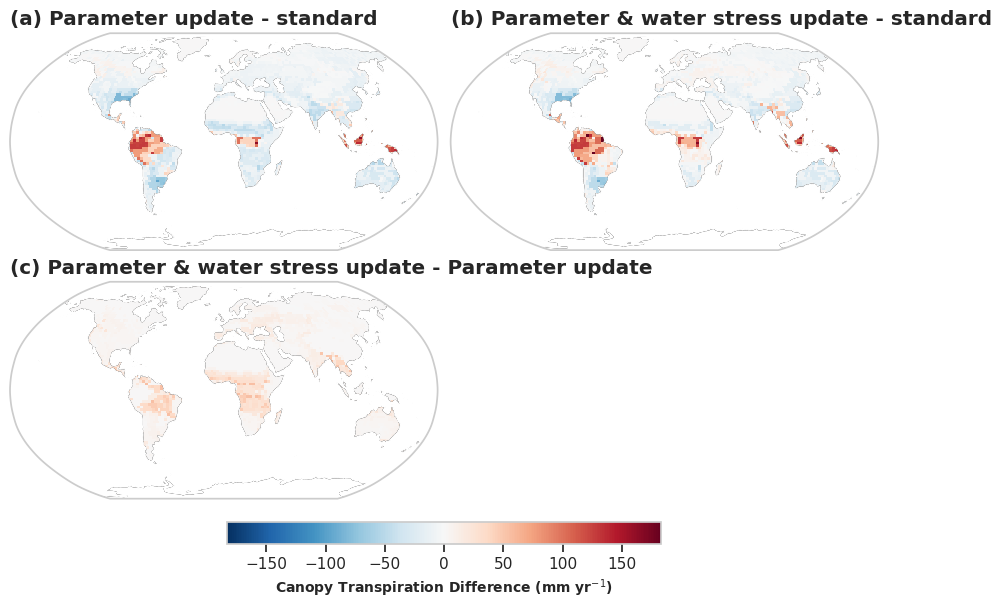

In [157]:
variable = 'QVEGT'
long_name = var_dict[variable]['long_name']
units = var_dict[variable]['annual_units']
diff2_0 = fates_ens_default2[variable]*ds_frac.landfrac - fates_ens_default[variable]*ds_frac.landfrac
diff3_2 = fates_ens_default3[variable]*ds_frac.landfrac - fates_ens_default2[variable]*ds_frac.landfrac
diff3_0 = fates_ens_default3[variable]*ds_frac.landfrac - fates_ens_default[variable]*ds_frac.landfrac

vmax = np.max([np.abs(diff2_0).max(), np.abs(diff3_2).max(), np.abs(diff3_0).max()])

figure, axes = plotting.generate_subplots(3)
axes = axes.flatten()
plotting.map_function(
    axes[0], diff2_0, '(a) Parameter update - standard', 'RdBu_r', vmin=vmax*-1, vmax=vmax, diverging_cmap=False)
plotting.map_function(
    axes[1], diff3_2, '(c) Parameter & water stress update - Parameter update', 'RdBu_r', vmin=vmax*-1, vmax=vmax, diverging_cmap=False)
pcm = plotting.map_function(
    axes[2], diff3_0, '(b) Parameter & water stress update - standard', 'RdBu_r', vmin=vmax*-1, vmax=vmax, diverging_cmap=False)
cbar = figure.colorbar(
    pcm, ax=axes.ravel().tolist(), shrink=0.5, orientation="horizontal"
)
cbar.set_label(f"{long_name} Difference ({units})", size=10, fontweight="bold")
plt.savefig(os.path.join(fig_dir, 'supplementary_figs',  'QVEGT_global_updates.png'), bbox_inches='tight')

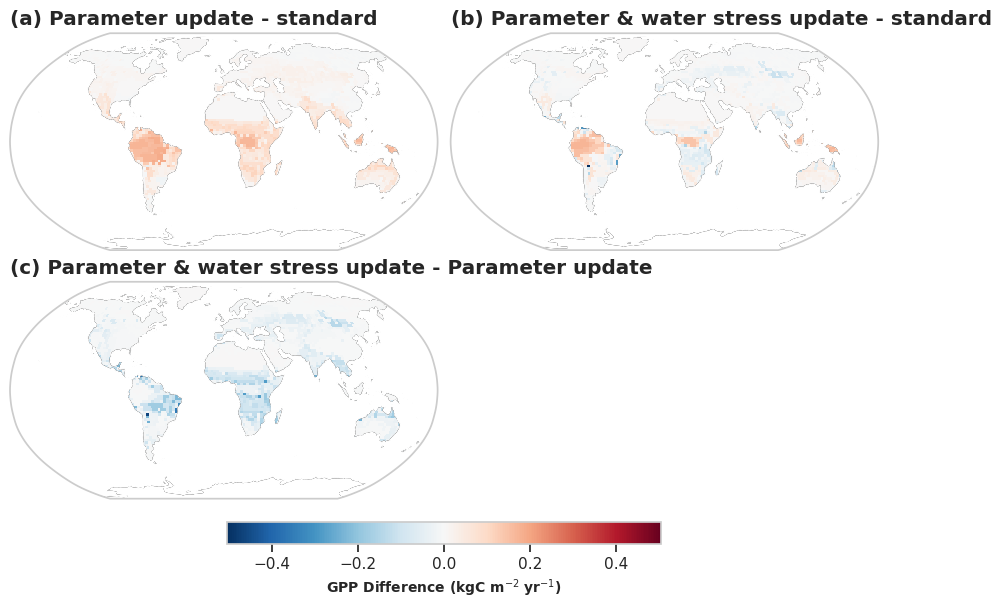

In [158]:
variable = 'GPP'
long_name = var_dict[variable]['long_name']
units = var_dict[variable]['annual_units']
diff2_0 = fates_ens_default2[variable]*ds_frac.landfrac - fates_ens_default[variable]*ds_frac.landfrac
diff3_2 = fates_ens_default3[variable]*ds_frac.landfrac - fates_ens_default2[variable]*ds_frac.landfrac
diff3_0 = fates_ens_default3[variable]*ds_frac.landfrac - fates_ens_default[variable]*ds_frac.landfrac

vmax = np.max([np.abs(diff2_0).max(), np.abs(diff3_2).max(), np.abs(diff3_0).max()])

figure, axes = plotting.generate_subplots(3)
axes = axes.flatten()
plotting.map_function(
    axes[0], diff2_0, '(a) Parameter update - standard', 'RdBu_r', vmin=vmax*-1, vmax=vmax, diverging_cmap=False)
plotting.map_function(
    axes[1], diff3_2, '(c) Parameter & water stress update - Parameter update', 'RdBu_r', vmin=vmax*-1, vmax=vmax, diverging_cmap=False)
pcm = plotting.map_function(
    axes[2], diff3_0, '(b) Parameter & water stress update - standard', 'RdBu_r', vmin=vmax*-1, vmax=vmax, diverging_cmap=False)
cbar = figure.colorbar(
    pcm, ax=axes.ravel().tolist(), shrink=0.5, orientation="horizontal"
)
cbar.set_label(f"{long_name} Difference ({units})", size=10, fontweight="bold")
plt.savefig(os.path.join(fig_dir, 'supplementary_figs', 'GPP_global_updates.png'), bbox_inches='tight')

### Figures S38

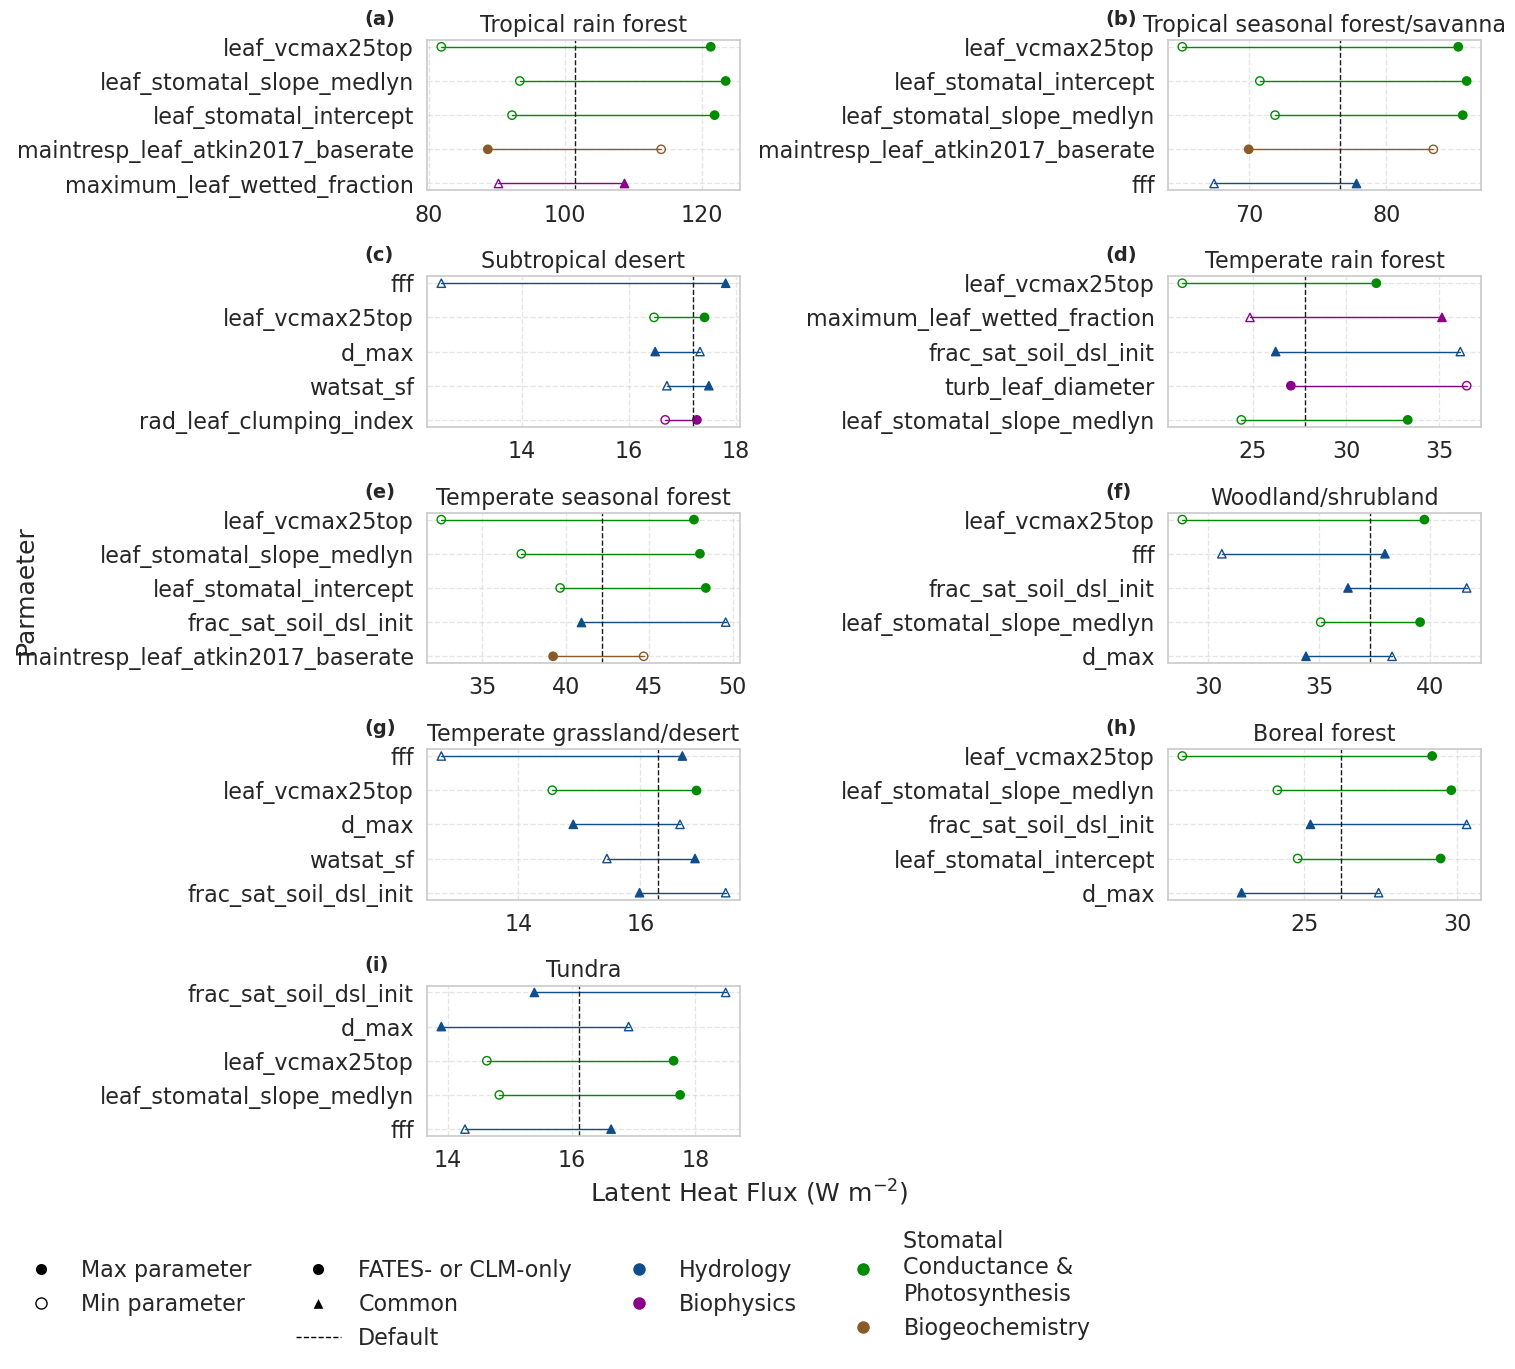

In [159]:
variable = 'EFLX_LH_TOT'
fates_biome_top5 = proc.get_biome_top_n(fates_biome_combo_mean, fates_biome_df,
                                        variable, n=5)
plotting.plot_top_n(fates_biome_top5,
                    fates_biome_combo_mean.sel(ensemble=0),
                    all_params,
                    variable, var_dict[variable]['long_name'],
                    var_dict[variable]['global_units'], by_biomes=True, width=15)
plt.savefig(os.path.join(fig_dir,  'supplementary_figs', 'EFLX_LH_TOT_FATES_top_5.png'), bbox_inches='tight')